Εισαγωγή
Η βιομηχανία ημιαγωγών αναπτύσσεται με ταχείς ρυθμούς. Οι τεχνικές της επιστήμης δεδομένων και της μηχανικής μάθησης χρησιμοποιούνται για την ανίχνευση ελαττωμάτων και για τον καλύτερο έλεγχο των διαδικασιών τους στην κατασκευή ημιαγωγών. Στο παρόν έργο, θα δείξουμε πώς η επιστήμη δεδομένων μπορεί να χρησιμοποιηθεί στη διαδικασία κατασκευής πλακών ημιαγωγών για να αποκαλύψει τα μοτίβα ελαττωμάτων μέσω της ανάλυσης δεδομένων ελαττωμάτων της πλάκας.

1.1. Υπόβαθρο
Ένα κύτταρο (die), στο πλαίσιο των ημιαγωγών, είναι ένα μικρό τμήμα της πλάκας στην οποία κατασκευάζεται ένα λειτουργικό κύκλωμα. Η πλάκα κόβεται (διαχωρίζεται) σε πολλά κομμάτια, καθένα από τα οποία περιέχει ένα αντίγραφο του κυκλώματος. Κάθε ένα από αυτά τα κομμάτια ονομάζεται κύτταρο (die).






In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/wm811k-wafer-map/LSWMD.pkl


In [2]:
# Show wafer bin map example from the internet

from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://www.disco.co.jp/eg/introduction/img/what_pc.png", width=600)

1.2. Στόχος

Αυτό το έργο θα πειραματιστεί με τρία μοντέλα πολυκατηγοριών για την αυτόματη αναγνώριση τύπων ελαττωμάτων στο wafer map κατά τη διάρκεια των διαδικασιών κατασκευής ημιαγωγών, βασισμένο σε πραγματικά δεδομένα εικόνας wafer map. Επιλέχθηκαν τρία δημοφιλή μοντέλα βασισμένα στη μηχανική μάθηση (ML):

Support Vector Machine (SVM)

Logistic Regression (LR)

Random Forest Classifier

Για να αποδειχθεί η απόδοση του προτεινόμενου μοντέλου, συγκρίνουμε τα τρία προτεινόμενα μοντέλα μεταξύ τους για να δούμε ποιο έχει την καλύτερη απόδοση.

Ο στόχος αυτού του έργου είναι να εντοπιστούν σωστά τα μοτίβα αποτυχίας των κυττάρων σε μια πλάκα. Τα αναγνωρισμένα μοτίβα ελαττωμάτων χρησιμοποιούνται από μηχανικούς και ειδικούς για να συνδεθούν με τις παραμέτρους της διαδικασίας για ανάλυση ριζικών αιτίων, έτσι ώστε να ληφθούν τα κατάλληλα διορθωτικά και προληπτικά μέτρα για τη βελτίωση της απόδοσης. Η χειροκίνητη ανάλυση των WBMs είναι μια εξαιρετικά χρονοβόρα διαδικασία και οδηγεί σε υψηλό περιθώριο σφάλματος αν το υποσύνολο που εξετάζεται χειροκίνητα δεν είναι αντιπροσωπευτικό για ολόκληρη την παρτίδα των WBMs. Επομένως, η χρήση της μηχανικής μάθησης για την αναγνώριση των μοτίβων αποτυχίας των κυττάρων θα μειώσει τη χειρωνακτική εργασία, ενώ η πρώιμη ανίχνευση εξοικονομεί υλικά και προσπάθεια.

The experiment is conducted using the real-time wafer map dataset WM-811K. The data is available on Kaggle: https://www.kaggle.com/qingyi/wm811k-wafer-map. This is a public dataset from the Multimedia Information Retrieval (MIR) lab (http://mirlab.org/dataset/public/).

2.2. Χαρακτηριστικά Δεδομένων
Το σύνολο δεδομένων περιλαμβάνει τα εξής χαρακτηριστικά:

ID: Ένας μοναδικός αριθμός αναγνώρισης για κάθε wafer map.

Lot ID: Ο αριθμός της παρτίδας από την οποία προέρχεται το wafer.

Wafer Map Image: Η εικόνα του wafer map που καταγράφει την κατανομή των ελαττωμάτων στην πλάκα. Κάθε εικόνα αντιπροσωπεύει την κατάσταση των κυττάρων της πλάκας και μπορεί να περιέχει διάφορους τύπους ελαττωμάτων.

Failure Type: Ο τύπος του ελαττώματος που εντοπίζεται στην πλάκα. Οι διαθέσιμοι τύποι ελαττωμάτων είναι οι εξής:

Center (Κέντρο)

Donut (Δακτύλιος)

Local (Τοπικό)

Edge-Local (Τοπικό Άκρο)

Edge-Ring (Δακτύλιος Άκρου)

Scratch (Γρατζουνιά)

Random (Τυχαίο)

Near-Full (Πλησίον Πλήρους)

None (Κανένα Ελάττωμα)

Lot Size: Το μέγεθος της παρτίδας, δηλαδή ο αριθμός των wafers που περιλαμβάνονται στην εν λόγω παρτίδα.

Process Parameters: Διάφοροι παράμετροι της διαδικασίας κατασκευής που επηρεάζουν την ποιότητα του ημιαγωγού, όπως η θερμοκρασία, η πίεση, ο χρόνος και άλλοι παράγοντες.

Defect Location: Οι συντεταγμένες ή η περιοχή της πλάκας όπου εντοπίζεται το ελάττωμα, που συνήθως υποδεικνύονται στο wafer map.

Failure Status: Η κατάσταση του wafer, δηλαδή αν είναι επιτυχημένο ή αποτυχημένο, με βάση την ανίχνευση ελαττωμάτων στο wafer map.

Αυτό το σύνολο δεδομένων επιτρέπει την ανάλυση και αναγνώριση μοτίβων ελαττωμάτων σε κάθε wafer, παρέχοντας σημαντικές πληροφορίες για τη διαδικασία κατασκευής και την ποιότητα του προϊόντος.




In [4]:
# Read data file

import pandas as pd
df = pd.read_pickle("/kaggle/input/wm811k-wafer-map/LSWMD.pkl")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   waferIndex      811457 non-null  float64
 4   trianTestLabel  811457 non-null  object 
 5   failureType     811457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


Το σύνολο δεδομένων περιέχει επιπλέον πληροφορίες σχετικά με τα wafer maps, όπως το μέγεθος των κυττάρων της πλάκας, το όνομα της παρτίδας και ο δείκτης της πλάκας (25 πλάκες ανά παρτίδα).

Τα σύνολα εκπαίδευσης/δοκιμής έχουν ήδη διαχωριστεί από ειδικούς του τομέα σε αυτό το σύνολο δεδομένων, αλλά αυτές οι ετικέτες θα αγνοηθούν.

In [5]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import random
# Show sample of dataset

df.head()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,[[Training]],[[none]]
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,[[Training]],[[none]]
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,[[Training]],[[none]]
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,[[Training]],[[none]]
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,[[Training]],[[none]]


Η στήλη waferMap περιέχει τον χάρτη των πλακών (wafer bin map), pixel προς pixel. Για λόγους απλότητας, κάθε κύτταρο στον WBM θεωρείται αποτυχημένο αν αποτύχει σε τουλάχιστον ένα τεστ, και διαφορετικά θεωρείται λειτουργικό. Αν ένα κύτταρο σε μια πλάκα αποτύχει, σημειώνεται με 2, ενώ αν περάσει το τεστ σημειώνεται με 1. Συνεπώς, κάθε pixel έχει μια κατηγορηματική μεταβλητή που εκφράζει:

0: Δεν είναι πλάκα

1: Κανονικό

2: Ελαττωματικό

Η στήλη waferIndex υποδεικνύει τον δείκτη της πλάκας σε μια παρτίδα των 25 πλακών. Επειδή αυτό, θα αλλάξουμε τον τύπο της στήλης waferIndex σε ακέραιο (integer). Επίσης, θα διορθώσουμε τη στήλη trianTestLabel στη σωστή ορθογραφία σε trainTestLabel.

In [6]:
# Correct columns

df.rename(columns={'trianTestLabel':'trainTestLabel'}, inplace=True)
df.waferIndex = df.waferIndex.astype(int)
df.tail()

,waferMap,dieSize,lotName,waferIndex,trainTestLabel,failureType
811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,23,[[Test]],[[Edge-Ring]]
811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,24,[[Test]],[[Edge-Loc]]
811454,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,25,[[Test]],[[Edge-Ring]]
811455,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47543,1,[],[]
811456,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47543,2,[],[]


Από τη στήλη lotName, το σύνολο δεδομένων έχει συλλεχθεί από 47.543 παρτίδες. Ωστόσο, αν πολλαπλασιάσουμε 47.543 παρτίδες x 25 wafers/παρτίδα = 1.157.325 wafer maps, το οποίο είναι μεγαλύτερο από τα 811.457 wafer maps που υπάρχουν στο σύνολο δεδομένων. Υποψιάζομαι ότι δεν όλες οι παρτίδες περιέχουν 25 wafers, καθώς η τελευταία παρτίδα έχει μόνο 2 wafers.

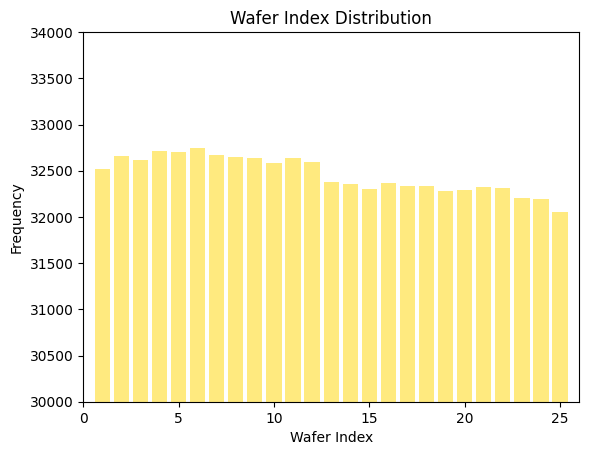

In [7]:
# Visualize wafer index distribution

uni_Index = np.unique(df.waferIndex, return_counts=True)
plt.bar(uni_Index[0],uni_Index[1], color='gold', align='center', alpha=0.5)
plt.title("Wafer Index Distribution")
plt.xlabel("Wafer Index")
plt.ylabel("Frequency")
plt.xlim(0,26)
plt.ylim(30000,34000)
plt.show()

In [8]:
# Drop column for wafer index

df = df.drop(['waferIndex'], axis = 1)


In [9]:
# Add column for wafer map dimension

def find_dim(x):
    dim0=np.size(x,axis=0)
    dim1=np.size(x,axis=1)
    return dim0,dim1
df['waferMapDim']=df.waferMap.apply(find_dim)
df.sample(5)
#Από τη στήλη dieSize, βλέπουμε ότι το μέγεθος του κυττάρου (die size) διαφέρει για κάθε περίπτωση.
#Δημιουργούμε μια νέα μεταβλητή waferMapDim για να ελέγξουμε τις διαστάσεις των wafer maps.

,waferMap,dieSize,lotName,trainTestLabel,failureType,waferMapDim
257640,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",4919.0,lot15945,[],[],"(84, 74)"
129541,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",5082.0,lot8483,[],[],"(87, 74)"
426051,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",6052.0,lot25602,[],[],"(86, 89)"
54100,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1304.0,lot4364,[],[],"(41, 41)"
26270,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1,...",741.0,lot2858,[],[],"(33, 29)"


In [10]:
# Wafer dimension distribution

#max(df.waferMapDim), min(df.waferMapDim)
uni_waferDim=np.unique(df.waferMapDim, return_counts=True)
#uni_waferDim[0].shape[0]
df['waferMapDim'].value_counts(normalize = True)

waferMapDim
(32, 29)    0.133941
(25, 27)    0.078973
(49, 39)    0.048460
(26, 26)    0.037067
(30, 34)    0.036370
              ...   
(53, 70)    0.000001
(99, 69)    0.000001
(38, 50)    0.000001
(45, 47)    0.000001
(27, 71)    0.000001
Name: proportion, Length: 632, dtype: float64

Οι διαστάσεις του wafer map, ή το μέγεθος της εικόνας, δεν είναι πάντα το ίδιο. Παρατηρούμε ότι υπάρχουν 632 διαφορετικά μεγέθη για τα wafer maps. Υπάρχει ποικιλία στις διαστάσεις των wafer maps και δεν είναι όλα τέλεια κυκλικά.

Για αυτόν τον λόγο, πρέπει να πραγματοποιήσουμε μετασχηματισμό δεδομένων (εξαγωγή χαρακτηριστικών) για να κανονικοποιήσουμε τις διαστάσεις εισόδου, και η μέθοδος θα εισαχθεί αργότερα.

Βλέπουμε επίσης ότι οι στήλες trianTestLabel και failureType δεν αποθηκεύονται με τον βέλτιστο τύπο δεδομένων. Δεδομένου ότι πρόκειται για ένα μεγάλο σύνολο δεδομένων, θα εξετάσουμε τους τύπους δεδομένων και τη χρήση μνήμης για να δούμε πού μπορούμε να χρησιμοποιήσουμε πιο αποδοτικούς τύπους δεδομένων.

In [11]:
# Dataframe memory usage

df.memory_usage(deep = True)  # memory usage in bytes

Index                   132
waferMap          353495858
dieSize             6491656
lotName            78547197
trainTestLabel    113995032
failureType       113448400
waferMapDim        51933248
dtype: int64

In [12]:
# Create a copy of dataset

df2 = df.copy()
df2.failureType = df2.failureType.apply(lambda x: x[0][0] if len(x) > 0 else float("NaN"))
df2.trainTestLabel = df2.trainTestLabel.apply(lambda x: x[0][0] if len(x) > 0 else float("NaN"))
df2.sample()

,waferMap,dieSize,lotName,trainTestLabel,failureType,waferMapDim
776113,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1485.0,lot46108,Test,none,"(39, 50)"


In [13]:
# Check new dataset memory usage

df2.memory_usage(deep = True)

Index                   132
waferMap          353495858
dieSize             6491656
lotName            78547197
trainTestLabel     36733994
failureType        36597336
waferMapDim        51933248
dtype: int64

Τώρα οι νέες στήλες καταλαμβάνουν σημαντικά λιγότερη μνήμη (37.000k αντί για 100.000k). Οι στήλες trainTestLabel και failureType έχουν μόνο μερικές μοναδικές τιμές, οπότε είναι καλές υποψήφιες για να μετατραπούν σε Categoricals. Με τη χρήση του τύπου Categoricals, αποθηκεύουμε κάθε μοναδικό όνομα μόνο μία φορά και χρησιμοποιούμε ακέραιους αριθμούς για να δείξουμε ποιο συγκεκριμένο όνομα χρησιμοποιείται σε κάθε γραμμή, κάτι που εξοικονομεί χώρο μνήμης.



In [14]:
# Cast categorical columns

df2['trainTestLabel'] = df2['trainTestLabel'].astype('category')
df2['failureType'] = df2['failureType'].astype('category')
df2.memory_usage(deep = True)

Index                   132
waferMap          353495858
dieSize             6491656
lotName            78547197
trainTestLabel       811755
failureType          812615
waferMapDim        51933248
dtype: int64

<Axes: ylabel='proportion'>

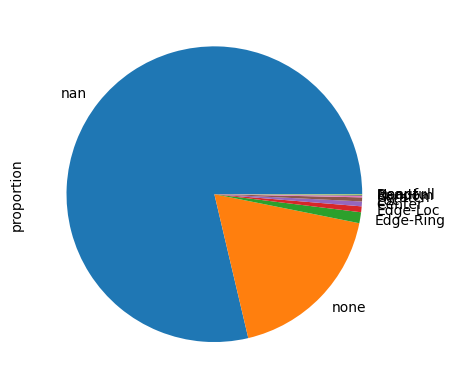

In [15]:
# Check falure type distribution

df2['failureType'].value_counts(dropna = False, normalize = True).plot.pie()

In [16]:
# Check failure type distribution of wafers with non-null labels

#df2['failureType'].value_counts().plot.bar()
df2['failureType'].value_counts()

failureType
none         147431
Edge-Ring      9680
Edge-Loc       5189
Center         4294
Loc            3593
Scratch        1193
Random          866
Donut           555
Near-full       149
Name: count, dtype: int64

In [17]:
# Check total number of images with non-null labels

df2['failureType'].value_counts().sum()

172950

Βλέπουμε επίσης ότι από το σύνολο δεδομένων, μόνο 172.950 εικόνες έχουν χειροκίνητα ετικέτες (συνολικά 9 ετικέτες: none, Edge-Ring, Edge-Loc, Center, Loc, Scratch, Random, Donut, και Near-full). Το 78,7% των wafers δεν έχουν ετικέτα σύμφωνα με το χαρακτηριστικό failureType. Μεταξύ των ετικετοποιημένων wafers, μόνο περίπου το 15% των wafers (25.519 wafers) έχουν πραγματικά μοτίβα αποτυχίας, ενώ 147.431 wafers έχουν ετικέτα "none".

Από τις 172.950 εικόνες, το μοτίβο none καταλαμβάνει το 85,2%. Το σύνολο δεδομένων είναι αταξινόμητο. Η κατηγορία Near-Full περιέχει μόνο 149 εικόνες. Επομένως, θα αφαιρέσουμε την κατηγορία Near-Full από τα πειραματικά δεδομένα και θα εστιάσουμε στις υπόλοιπες οκτώ κατηγορίες αποτυχιών wafer map. Επίσης, θα χρησιμοποιήσουμε τυχαία δειγματοληψία για να εξαγάγουμε 500 εικόνες από κάθε μία από τις οκτώ κατηγορίες από το αρχικό σύνολο δεδομένων, δημιουργώντας έτσι ένα σύνολο δεδομένων που θα περιλαμβάνει συνολικά 4.000 εικόνες. Στη συνέχεια, το σύνολο δεδομένων θα χωριστεί σε δεδομένα εκπαίδευσης και δεδομένα δοκιμής σε αναλογία 70% και 30%, αντίστοιχα.

Υπάρχουν επίσης πολλά κενά δεδομένα. Δεδομένου ότι ενδιαφερόμαστε μόνο για τα wafers με μοτίβα αποτυχίας, θα αφαιρέσουμε αυτά που δεν έχουν ετικέτα τύπου αποτυχίας. Αυτό θα μειώσει σημαντικά το μέγεθος του συνόλου δεδομένων.

Επιπλέον, προσθέτουμε δύο στήλες για να κωδικοποιήσουμε τις κατηγορίες αποτυχίας και τις ετικέτες εκπαίδευσης/δοκιμής.

Λόγω της μεθόδου εξαγωγής χαρακτηριστικών βασισμένων στην πυκνότητα, τα wafer maps πρέπει να είναι τουλάχιστον 5x5. Θα εφαρμόσουμε φίλτρο για να αφαιρέσουμε τα wafer maps που είναι μικρότερα από 5x5.

In [23]:
# Αφαίρεση των γραμμών που περιέχουν NaN στην στήλη 'failureNum'
df2 = df2.dropna(subset=['failureNum'])

# Επανακαθορισμός των κατηγοριών και αντικατάσταση των NaN
df2['failureNum'] = df2['failureNum'].cat.remove_unused_categories()
df2['failureNum'] = df2['failureNum'].astype(int)

# Διαγραφή των ανεξόφλητων δεδομένων και της κατηγορίας "Near-full"
df2 = df2[(df2['failureNum'] >= 0) & (df2['failureNum'] <= 8)]
df2 = df2[df2['failureType'] != 'Near-full']
df2['failureType'] = df2['failureType'].cat.remove_unused_categories()

# Φιλτράρισμα των wafer maps που είναι μικρότερα από 5x5
size_filter = [all(np.greater(df2['waferMapDim'].iloc[i], (5, 5))) for i in range(len(df2))]
df2 = df2[size_filter]

# Έλεγχος του τελικού μεγέθους του dataframe
df2.shape[0]



172799

In [25]:
import pandas as pd
import random

random.seed(10)
failure_types = list(df2['failureType'].cat.categories)
num_cat = len(failure_types)
df_list = []

for i_cat in range(num_cat):
    cat = failure_types[i_cat]
    sample = df2.loc[df2['failureType'] == cat].sample(500)
    df_list.append(sample)

# Συνένωση όλων των δειγμάτων
df = pd.concat(df_list, ignore_index=True)

# Εμφάνιση των κατανομών των κατηγοριών
df['failureType'].value_counts()


failureType
Center       500
Donut        500
Edge-Loc     500
Edge-Ring    500
Loc          500
Random       500
Scratch      500
none         500
Name: count, dtype: int64

Για να οπτικοποιήσουμε μερικούς από τους χάρτες του wafer και να δούμε τα μοτίβα αποτυχίας, μπορούμε να χρησιμοποιήσουμε την βιβλιοθήκη matplotlib για να απεικονίσουμε τα δεδομένα. Ο σκοπός είναι να παρατηρήσουμε την κατανομή των χρωμάτων, όπου το σκούρο μοβ αναπαριστά την περιοχή που δεν ανήκει στον wafer, το πράσινο δηλώνει ότι το die είναι λειτουργικό, και το κίτρινο ότι το die έχει αποτύχε

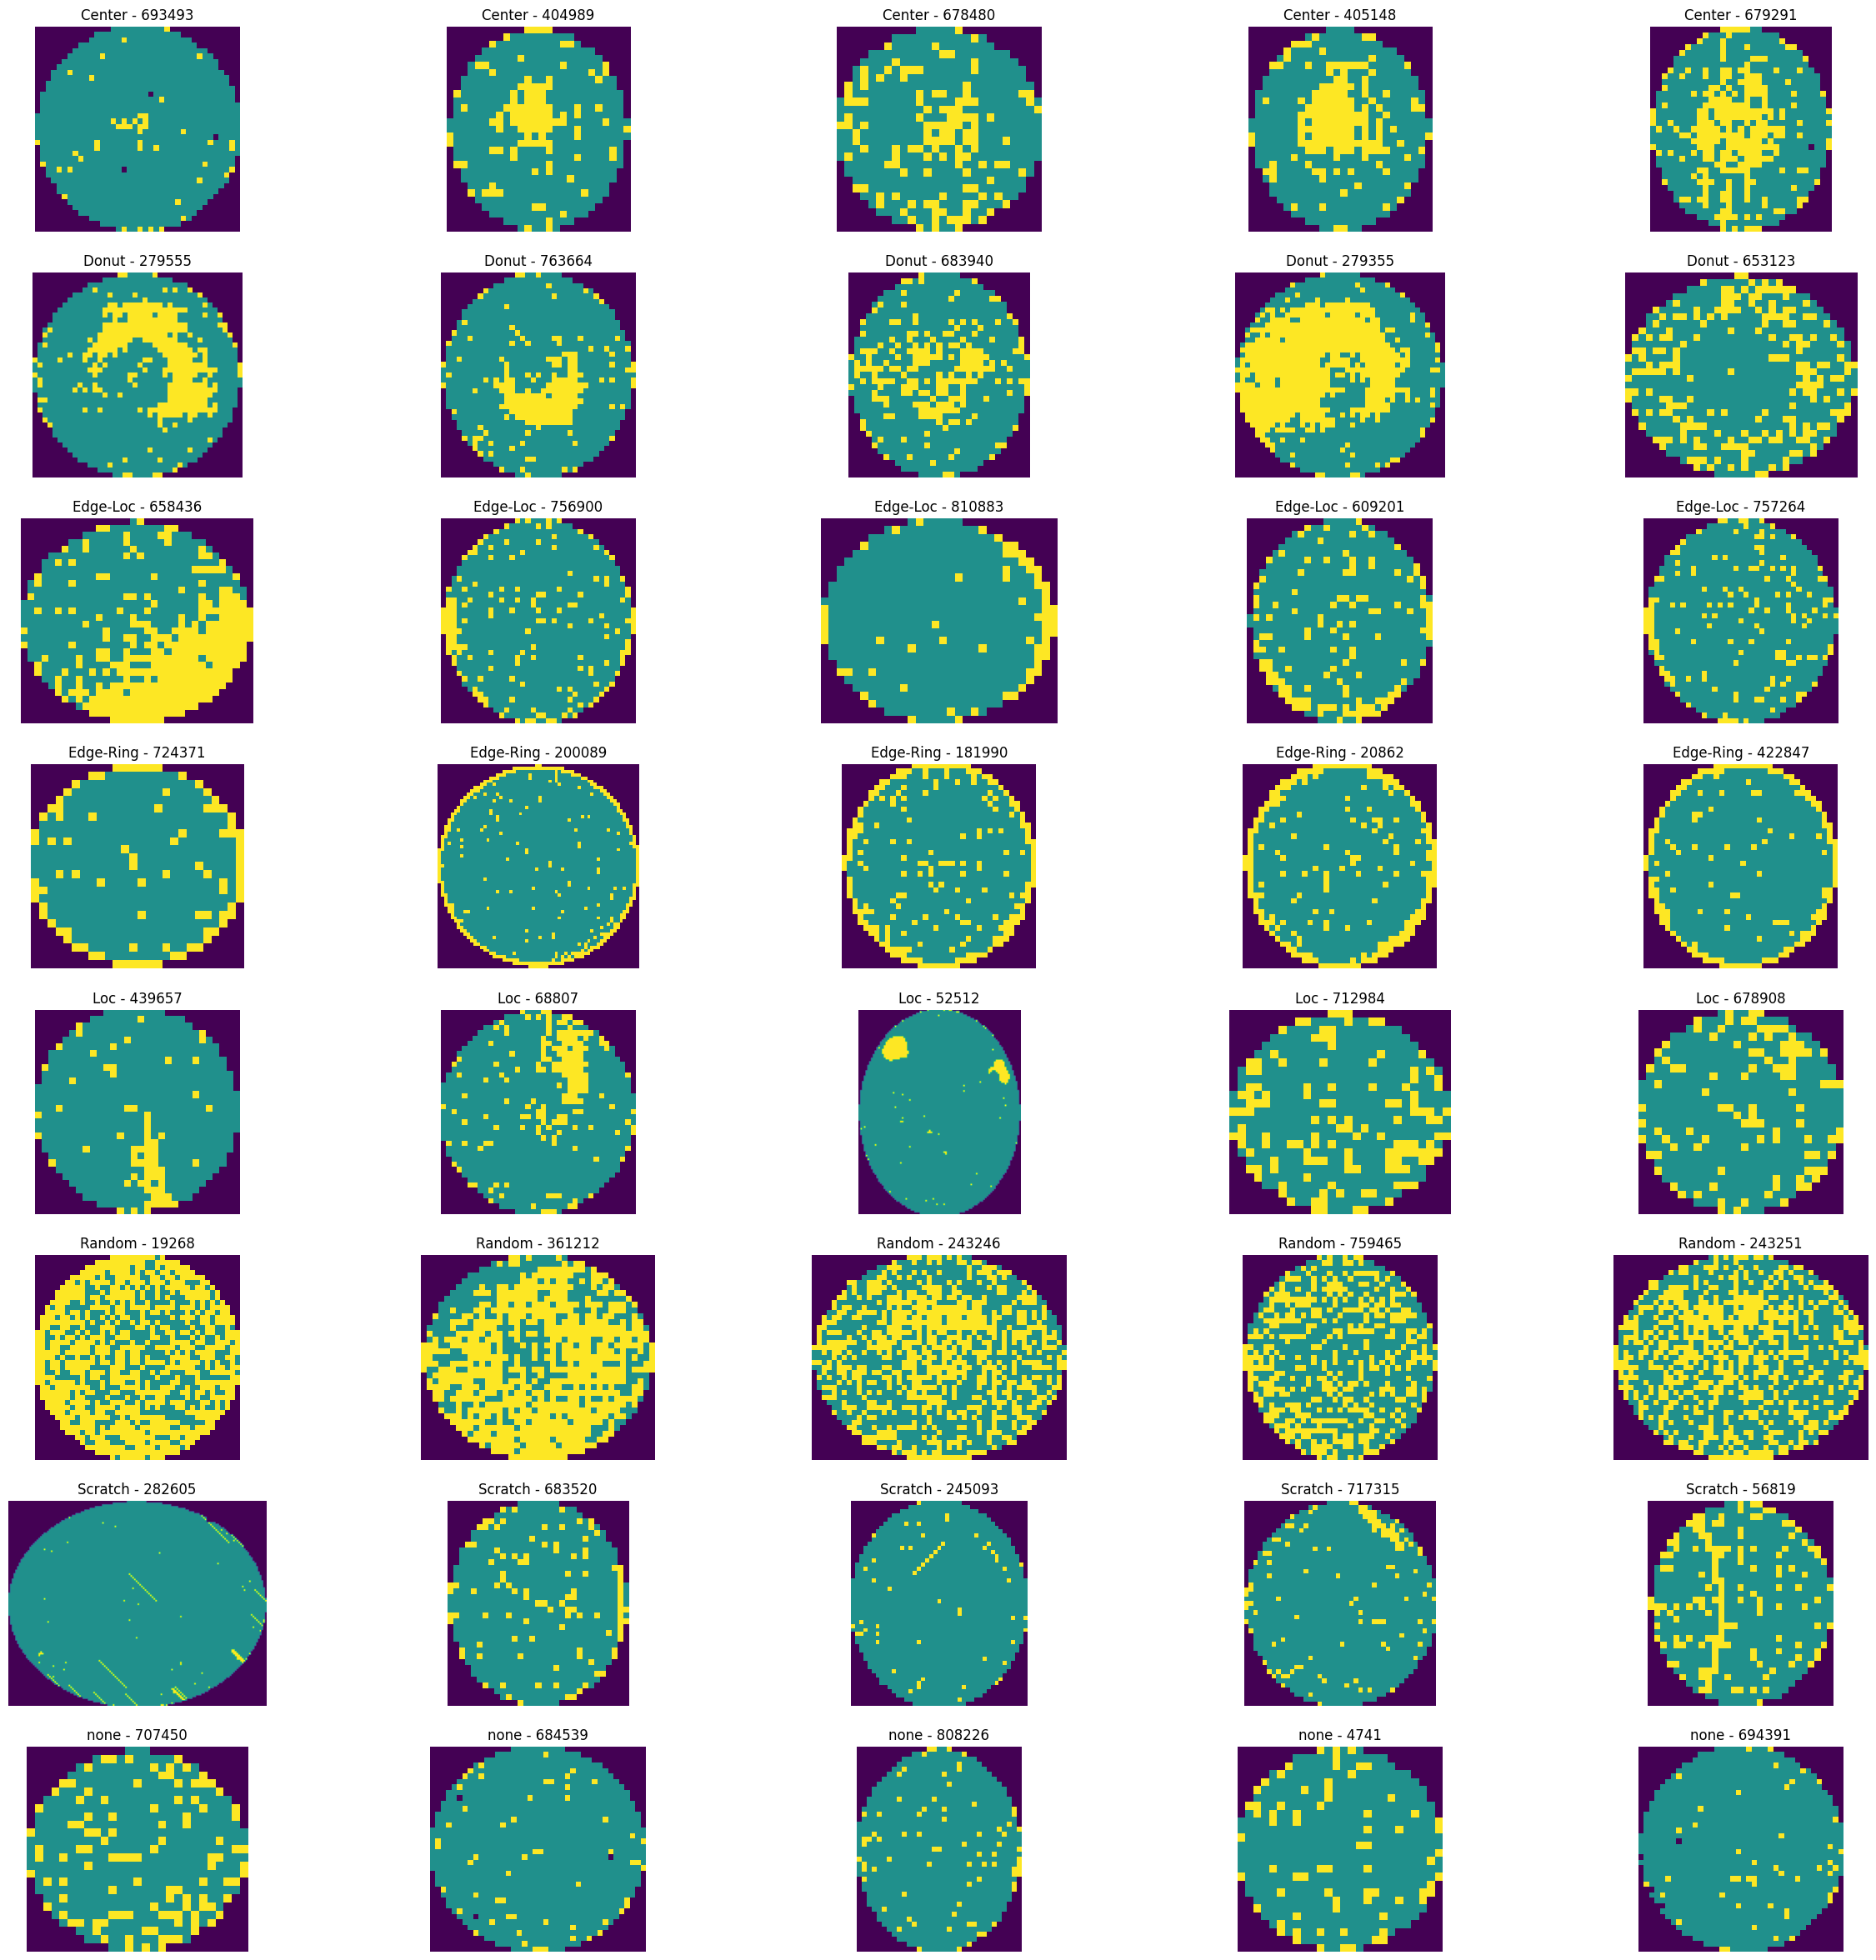

In [26]:

# Plot 5 of each failure type

sample_size = 5
fig, axs = plt.subplots(num_cat, sample_size, figsize = (30,30))
for i_cat in range(num_cat):
    cat = failure_types[i_cat]
    random.seed(10)
    sample = df2.loc[df2['failureType'] == cat].sample(sample_size)
    for i in range(len(sample)):
        index = sample.index[i]
        axs[i_cat, i].axis('off')
        axs[i_cat, i].imshow(sample['waferMap'][index])
        axs[i_cat, i].set_title(f'{cat} - {index}')

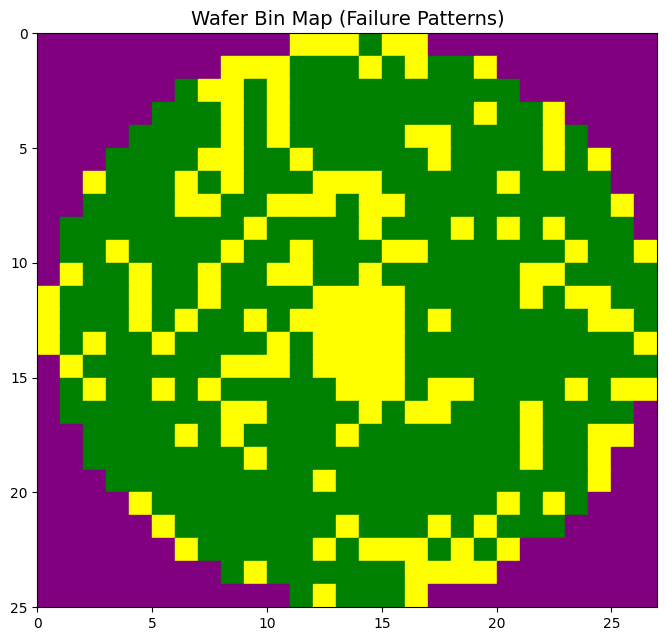

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Λάβετε ένα παράδειγμα wafer map από το DataFrame
example_wafer_map = df['waferMap'].iloc[0]  # Παράδειγμα πρώτου wafer map

# Αντιστοιχία των τιμών: 0 για όχι wafer, 1 για κανονικό, 2 για αποτυχημένο
color_map = {0: 'purple', 1: 'green', 2: 'yellow'}

# Δημιουργία της εικόνας του wafer map
fig, ax = plt.subplots(figsize=(8, 8))
for i in range(example_wafer_map.shape[0]):  # Γραμμές
    for j in range(example_wafer_map.shape[1]):  # Στήλες
        value = example_wafer_map[i, j]
        ax.add_patch(plt.Rectangle((j, i), 1, 1, color=color_map.get(value, 'white')))
        
# Ρυθμίσεις για καλύτερη εμφάνιση
ax.set_xlim(0, example_wafer_map.shape[1])
ax.set_ylim(0, example_wafer_map.shape[0])
ax.set_aspect('equal', 'box')
plt.gca().invert_yaxis()  # Αναστρέφει τον άξονα y για σωστή εμφάνιση
plt.title('Wafer Bin Map (Failure Patterns)', fontsize=14)
plt.show()


Η παραπάνω εικόνα δείχνει 5 τυχαία παραδείγματα από κάθε μία από τις οκτώ κατηγορίες αποτυχιών των wafer maps. Κάθε τύπος αποτυχίας έχει συγκεκριμένα χαρακτηριστικά που είναι ορατά στα wafer maps, τα οποία μπορεί να περιλαμβάνουν διάφορους τύπους ελαττωμάτων, όπως ρωγμές, τυχαία σφάλματα, προβλήματα με την τοποθέτηση των "dies", ή άλλες ασυνήθιστες μορφές που προκαλούν αποτυχίες στην κατασκευή.

In [28]:
# Look at train/test split

df['trainTestLabel'].value_counts(dropna = False, normalize = True)

trainTestLabel
Training    0.5965
Test        0.4035
Name: proportion, dtype: float64

Το σύνολο δεδομένων έχει ήδη χωριστεί σε εκπαιδευτικό και δοκιμαστικό σύνολο από το εργαστήριο MIR. Ωστόσο, μετά την αναδειγματοληψία (resampling), χρειαζόμαστε να δημιουργήσουμε έναν νέο διαχωρισμό για εκπαίδευση/δοκιμή. Επομένως, θα αγνοήσουμε αυτές τις ετικέτες και θα δημιουργήσουμε έναν νέο διαχωρισμό 70/30 για εκπαίδευση και δοκιμή αργότερα.

4.Προεπεξεργασία Δεδομένων και Μείωση Θορύβου
Δεδομένου ότι οι διαστάσεις των wafer maps διαφέρουν, θα εφαρμόσουμε μετασχηματισμό δεδομένων για να προετοιμάσουμε τα δεδομένα για μηχανική μάθηση, εφαρμόζοντας χαρακτηριστικά μέσω κλιμάκωσης, αποσύνθεσης χαρακτηριστικών και συσσώρευσης χαρακτηριστικών.

Επειδή ο στόχος της εργασίας είναι να εντοπίσουμε το μοτίβο στις αποτυχίες των πλακών αντί για τα μεμονωμένα σημεία αποτυχίας, είναι σημαντικό να μειώσουμε τον θόρυβο και να ενισχύσουμε το σήμα. Για να μειώσουμε τον θόρυβο στα WBM, χρησιμοποιούμε φιλτράρισμα με διάμεσο (median filtering).

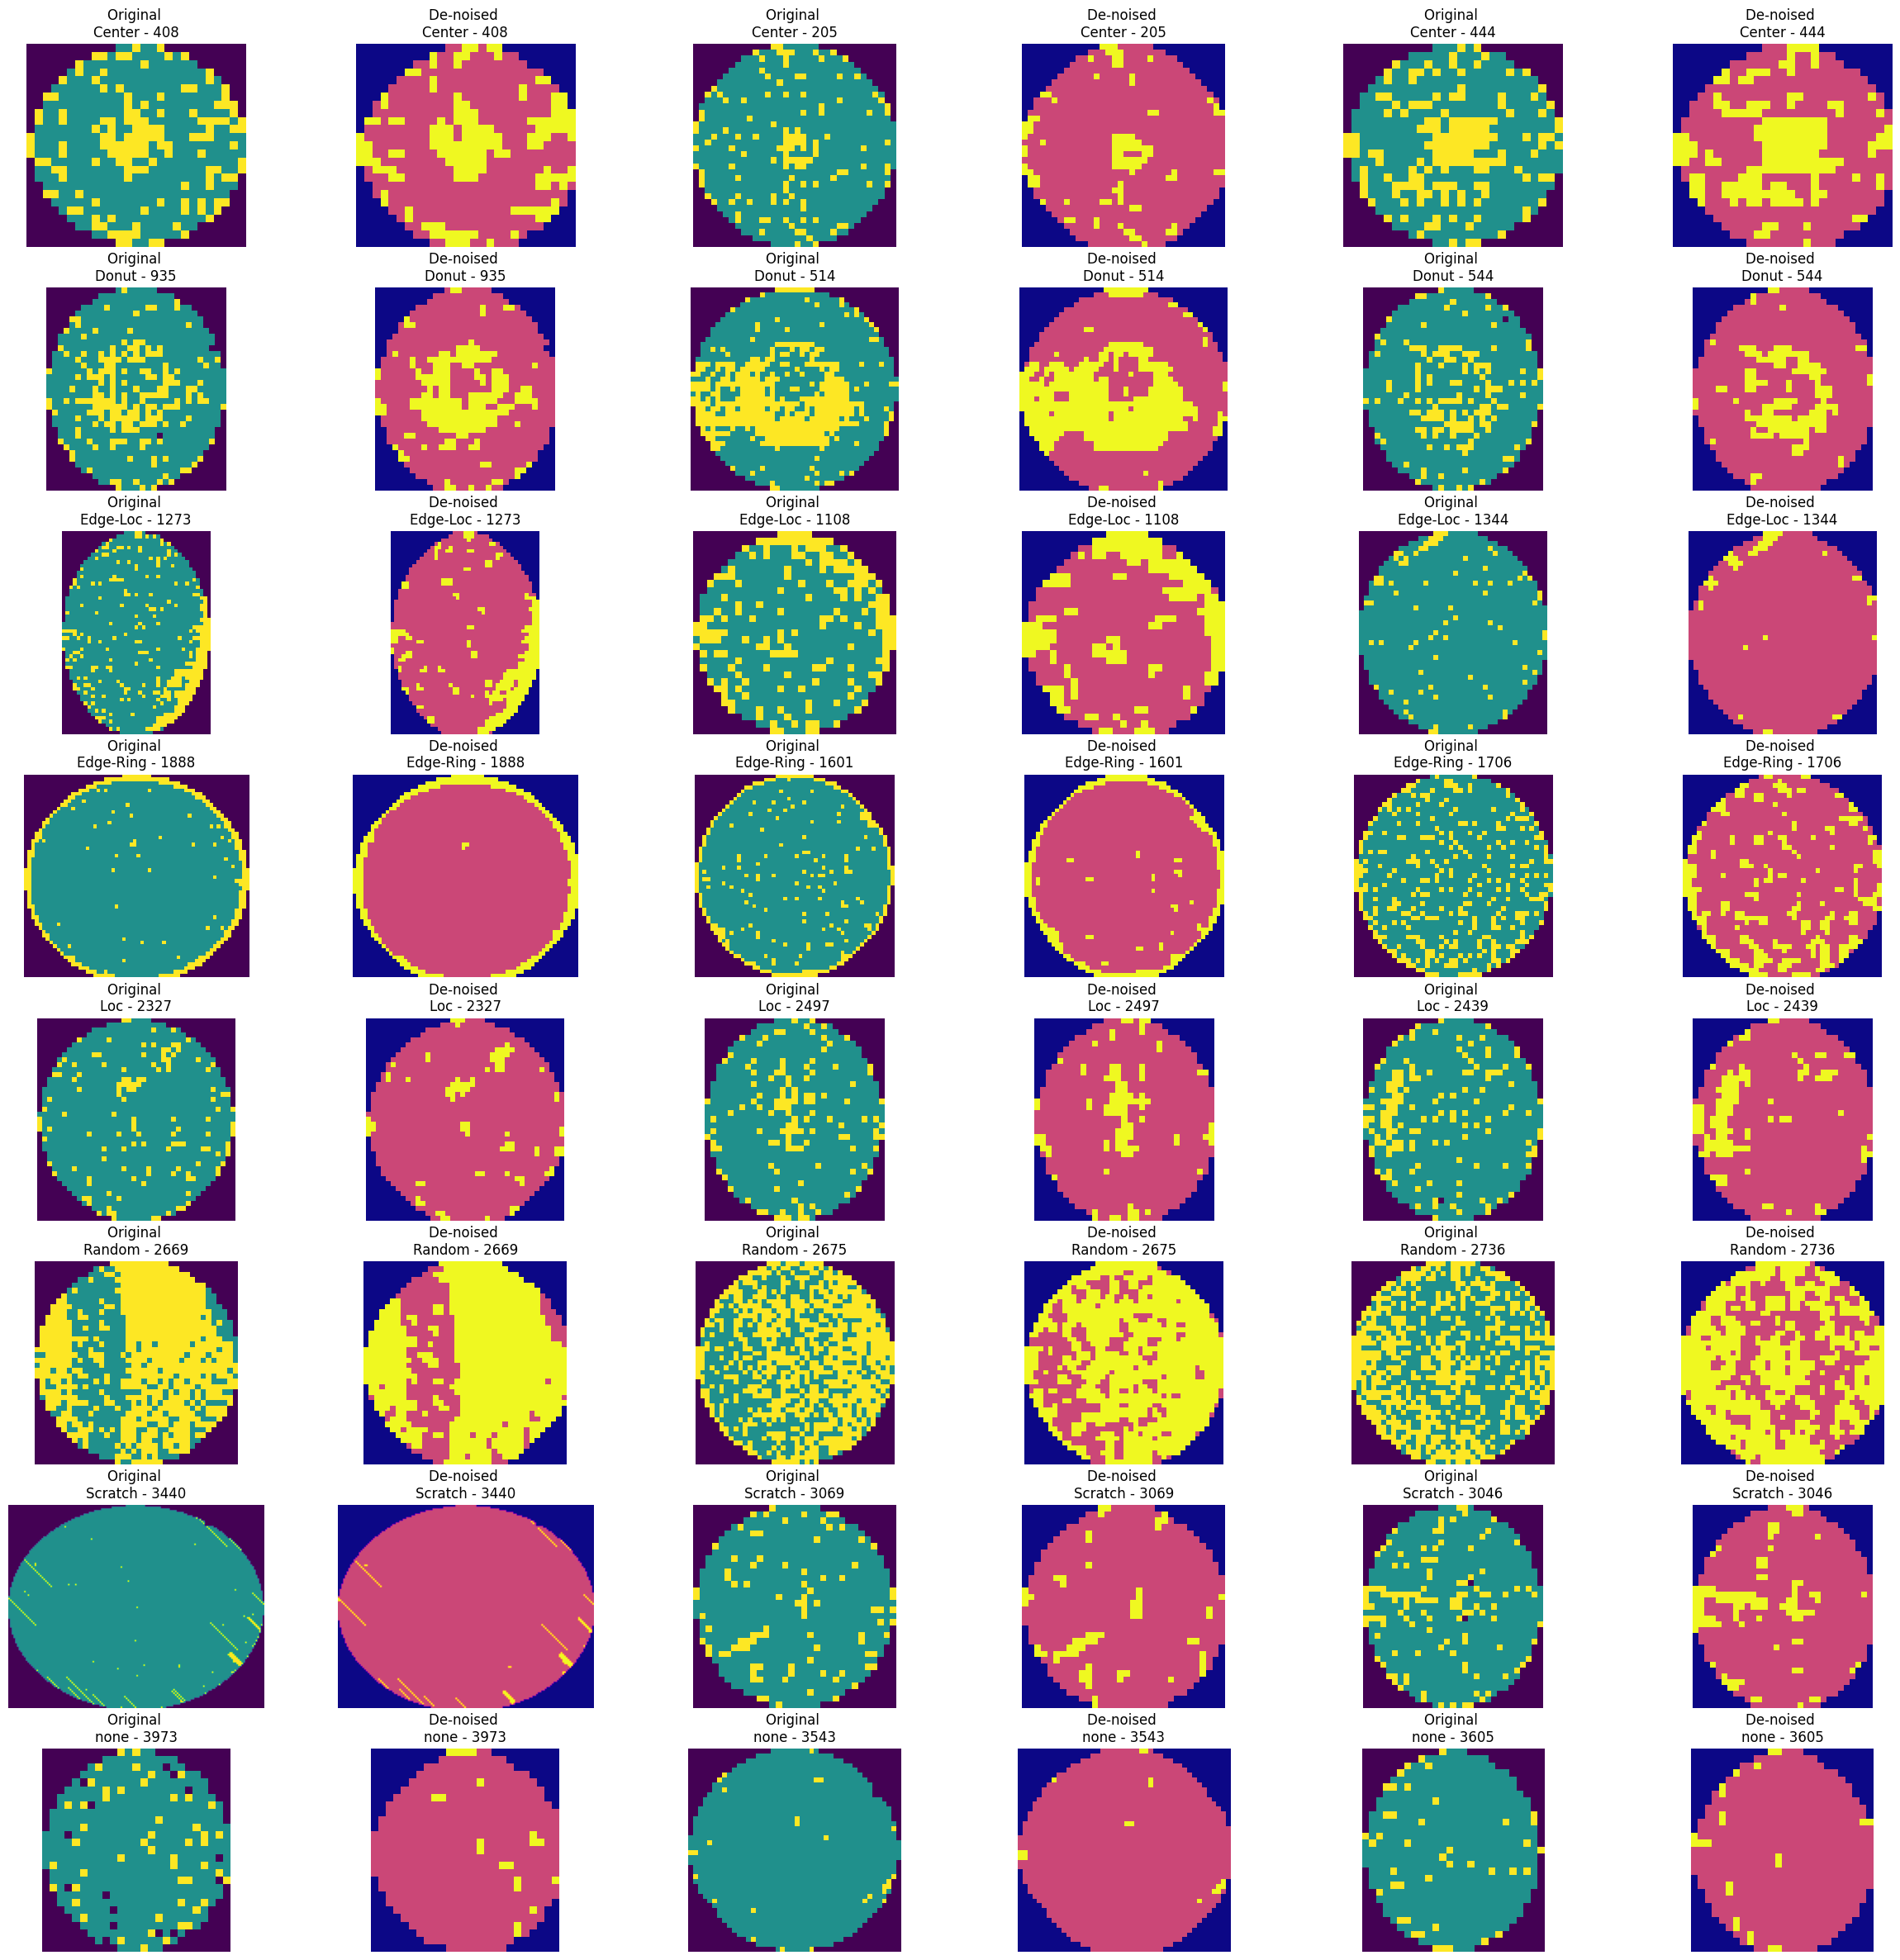

In [29]:
from scipy import ndimage
# Visualize denoising

#num_cat = len(df['failureType'].cat.categories)
sample_size = 3
fig, axs = plt.subplots(num_cat, sample_size * 2, figsize = (30,30))
for i_cat in range(num_cat):
    cat = df['failureType'].cat.categories[i_cat]
    random.seed(10)
    sample = df.loc[df['failureType'] == cat].sample(sample_size)
    for i in range(0, len(sample) * 2, 2):
        index = sample.index[int(i/2)]
        original = sample['waferMap'][index]
        denoised = ndimage.median_filter(original, size = (2,2))
        axs[i_cat, i].axis('off')
        axs[i_cat, i].imshow(original)
        axs[i_cat, i].set_title(f'Original \n{cat} - {index}')
        axs[i_cat, i + 1].axis('off')
        axs[i_cat, i + 1].imshow(denoised,  cmap=plt.get_cmap('plasma'))
        axs[i_cat, i + 1].set_title(f'De-noised \n{cat} - {index}')

Οι παραπάνω εικόνες δείχνουν συγκρίσεις του αρχικού wafer map και των αφαιρεμένων από θόρυβο (denoised) εικόνων. Για ευκολία σύγκρισης, οι εικόνες παρουσιάζονται δίπλα-δίπλα με διαφορετικό χρωματικό χάρτη.

In [30]:
import warnings
warnings.filterwarnings('ignore')
df3 = df.copy()
for i in range(len(df3['waferMap'])):
    original = df3['waferMap'].iloc[i]
    df3['waferMap'].iloc[i] = ndimage.median_filter(original, size = (2,2))

5.Εξαγωγή Χαρακτηριστικών
Αφού τα wafer maps καθαριστούν από τον θόρυβο, το επόμενο βήμα στην ανάλυση είναι η εξαγωγή χαρακτηριστικών από τα wafer bin maps. Θα υπάρχουν 13 χαρακτηριστικά βασισμένα στην πυκνότητα, 40 χαρακτηριστικά βασισμένα σε τυχαία δεδομένα και 6 γεωμετρικά χαρακτηριστικά.

5.1. Χαρακτηριστικά Βασισμένα στην Πυκνότητα (13)
Για να δημιουργηθούν τα χαρακτηριστικά βασισμένα στην πυκνότητα, το wafer bin map χωρίζεται σε 13 περιοχές. Οι 13 περιοχές περιλαμβάνουν την εσωτερική περιοχή 3x3 και τις περιοχές γύρω από τις άκρες του wafer map, όπως φαίνεται στην εικόνα παρακάτω. Η πυκνότητα των αποτυχιών σε κάθε περιοχή υπολογίζεται ως το ποσοστό των "2" (αποτυχημένα dies) στην περιοχή. Αυτά τα 13 χαρακτηριστικά εκπροσωπούν τη θέση των αποτυχιών στο wafer. Κάθε τύπος αποτυχίας θα έχει διαφορετικά μοτίβα κατανομής πυκνότητας. Μπορούμε να τα ορίσουμε ως εξής:

Center: Ο τύπος αποτυχίας θα πρέπει να έχει την υψηλότερη πυκνότητα αποτυχιών στην περιοχή 9.

Donut: Ο τύπος αποτυχίας θα πρέπει να έχει την υψηλότερη πυκνότητα αποτυχιών στις περιοχές γύρω από την κεντρική περιοχή, όπως οι περιοχές 5, 6, 7, 8, 10, 11, 12, και 13.

Edge-Local: Μία ή περισσότερες περιοχές από τις 1 έως τις 4 θα πρέπει να περιέχουν υψηλή πυκνότητα αποτυχιών.

Edge-Ring: Οι περιοχές 1 έως 4 θα πρέπει να έχουν υψηλή και ισομερή πυκνότητα αποτυχιών.

Local: Πολλές περιοχές από τις 5 έως τις 13 θα πρέπει να περιέχουν υψηλή πυκνότητα αποτυχιών.

Random: Κάθε περιοχή περιέχει σχεδόν παρόμοια πυκνότητα αποτυχιών.

Scratch: Τυχαία κατανομή πυκνότητας αποτυχιών.

None: Δεν υπάρχει συγκεκριμένη κατανομή πυκνότητας αποτυχιών σε καμία περιοχή.

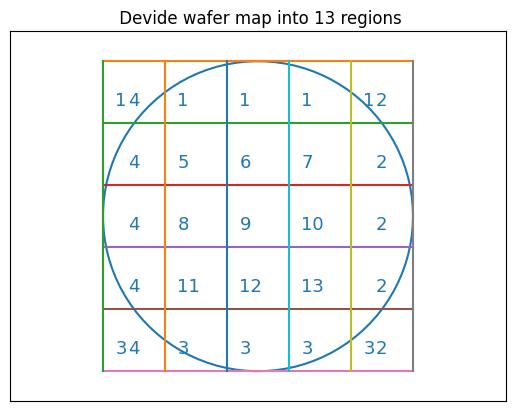

In [31]:

an = np.linspace(0, 2*np.pi, 100)
plt.plot(2.5*np.cos(an), 2.5*np.sin(an))
plt.axis('equal')
plt.axis([-4, 4, -4, 4])
for i in range(6):
    plt.plot([-2.5, 2.5], [2.5 - i, 2.5 - i])
for i in range(6):
    plt.plot([2.5 - i, 2.5 - i], [-2.5, 2.5])

# Number the regions

for i in range(5):
    plt.text(-2.3 + i, 1.8, 1, {'color': 'C0', 'fontsize': 13})
for i in range(5):
    plt.text(1.9, 1.8 - i, 2, {'color': 'C0', 'fontsize': 13})
for i in range(5):
    plt.text(-2.3 + i, -2.2, 3, {'color': 'C0', 'fontsize': 13})
for i in range(5):
    plt.text(-2.1, 1.8 - i, 4, {'color': 'C0', 'fontsize': 13})
for row in range(3):    
    for i in range(3):
        plt.text(-1.3 + i, 0.8 - row, i + 5 + row * 3, {'color': 'C0', 'fontsize': 13})
    
plt.title(" Devide wafer map into 13 regions")
plt.xticks([])
plt.yticks([])
plt.show()

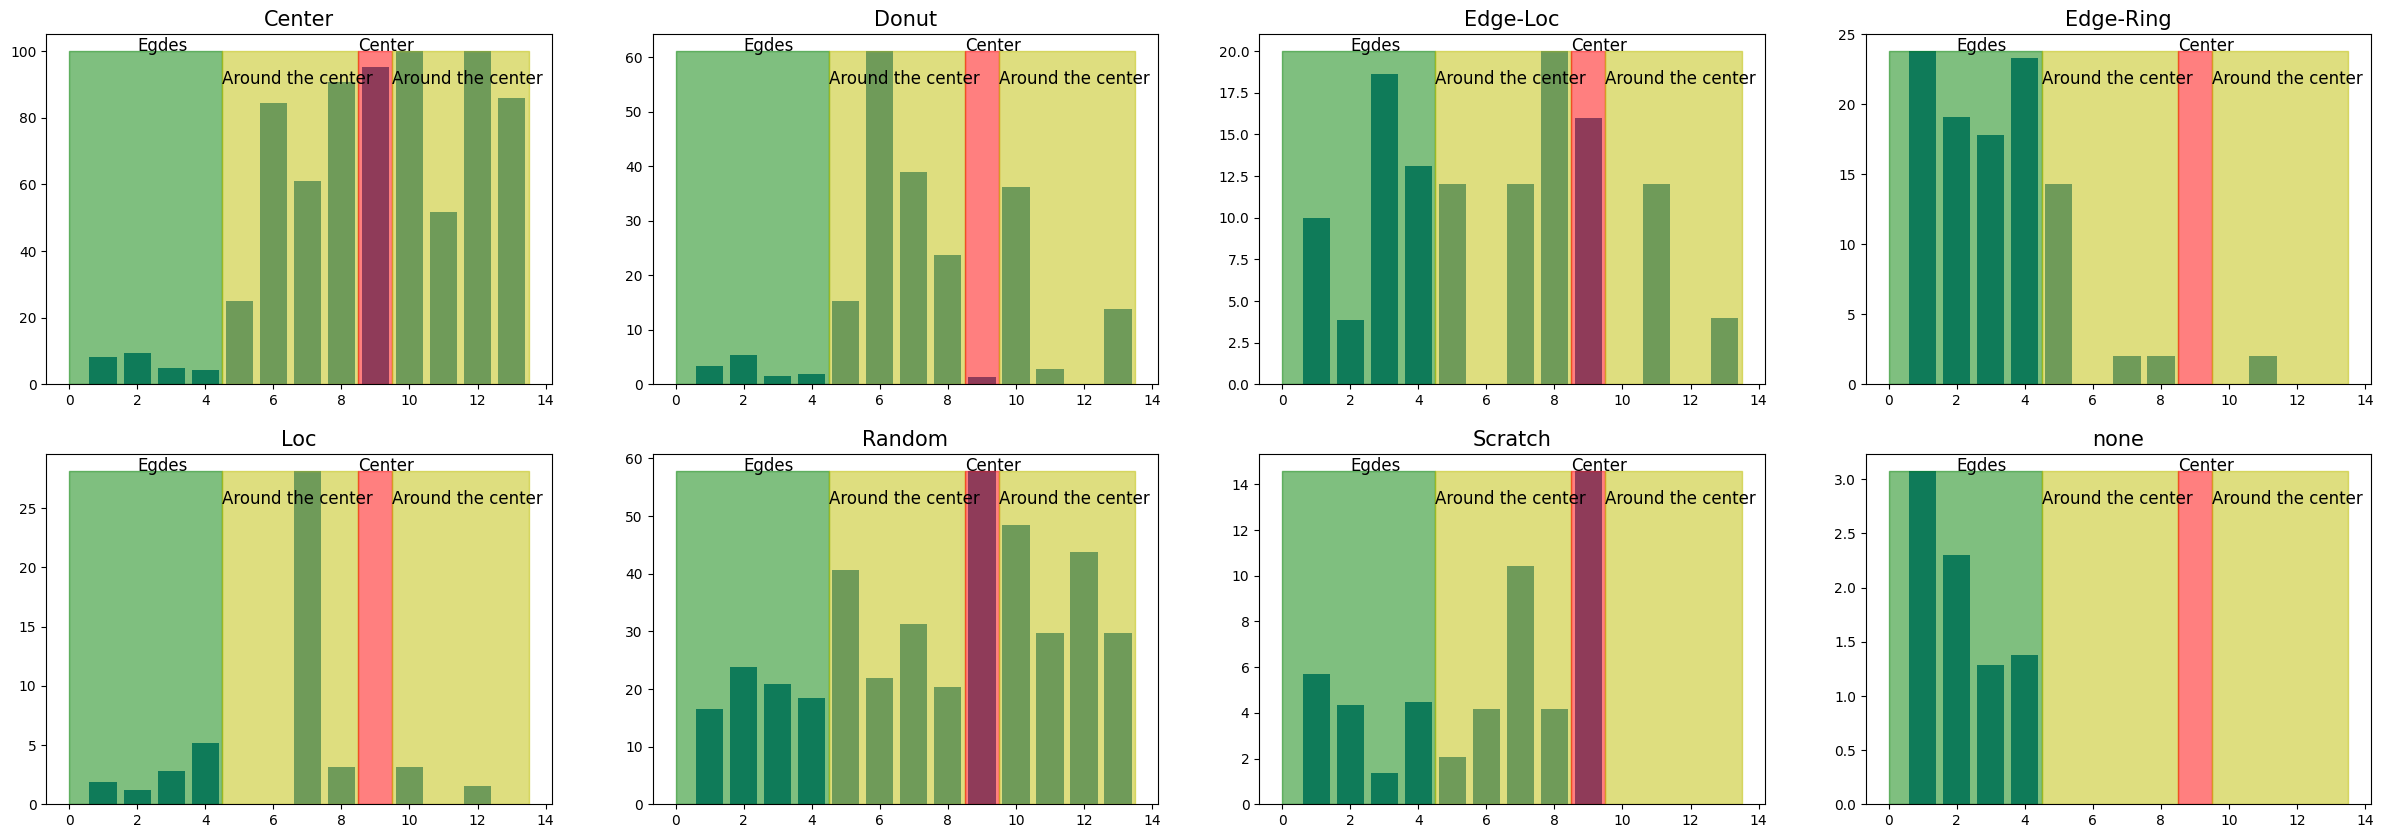

In [32]:
# Define functions to calculate densities of the regions

def cal_den(x):
    return 100 * (np.sum(x==2)/np.size(x))  

def find_regions(x):
    rows=np.size(x,axis=0)
    cols=np.size(x,axis=1)
    #print(cols)
    ind1=np.arange(0,rows,rows//5)
    ind2=np.arange(0,cols,cols//5)
    reg1=x[ind1[0]:ind1[1],:]
    reg2=x[:,ind2[4]:]
    reg3=x[ind1[4]:,:]
    reg4=x[:,ind2[0]:ind2[1]]
    reg5=x[ind1[1]:ind1[2],ind2[1]:ind2[2]]
    reg6=x[ind1[1]:ind1[2],ind2[2]:ind2[3]]
    reg7=x[ind1[1]:ind1[2],ind2[3]:ind2[4]]
    reg8=x[ind1[2]:ind1[3],ind2[1]:ind2[2]]
    reg9=x[ind1[2]:ind1[3],ind2[2]:ind2[3]]
    reg10=x[ind1[2]:ind1[3],ind2[3]:ind2[4]]
    reg11=x[ind1[3]:ind1[4],ind2[1]:ind2[2]]
    reg12=x[ind1[3]:ind1[4],ind2[2]:ind2[3]]
    reg13=x[ind1[3]:ind1[4],ind2[3]:ind2[4]]
        
    fea_reg_den = []
    fea_reg_den = [cal_den(reg1),cal_den(reg2),cal_den(reg3),cal_den(reg4),cal_den(reg5),cal_den(reg6),cal_den(reg7),cal_den(reg8),cal_den(reg9),cal_den(reg10),cal_den(reg11),cal_den(reg12),cal_den(reg13)]
    return fea_reg_den
# Apply the density calculation function

df3['fea_reg']=df3.waferMap.apply(find_regions)
# Visualize the density distributions

sample_size = 1
fig, axs = plt.subplots(nrows = 2, ncols = 4, figsize = (30,10))
axs = axs.ravel(order='C')
coordinates = [[()]]
for i in range(num_cat):
    cat = df3['failureType'].cat.categories[i]
    sample = df3.loc[df['failureType'] == cat].sample(sample_size)
    axs[i].bar(np.linspace(1,13,13), list(sample['fea_reg'])[0])
    axs[i].set_title(cat, fontsize=15)
    y_lim = max(list(sample['fea_reg'])[0])
    axs[i].fill_betweenx((0, y_lim), 0, 4.5, alpha=0.5, color = 'g')
    axs[i].fill_betweenx((0, y_lim), 4.5, 8.5, alpha=0.5, color = 'y')
    axs[i].fill_betweenx((0, y_lim), 8.5, 9.5, alpha=0.5, color = 'r')
    axs[i].fill_betweenx((0, y_lim), 9.5, 13.5, alpha=0.5, color = 'y')
    axs[i].text(2, y_lim, 'Egdes', {'color': 'k', 'fontsize': 12})
    axs[i].text(4.5, y_lim*0.9, 'Around the center', {'color': 'k', 'fontsize': 12})
    axs[i].text(8.5, y_lim, 'Center', {'color': 'k', 'fontsize': 12})
    axs[i].text(9.5, y_lim*0.9, 'Around the center', {'color': 'k', 'fontsize': 12})
    
plt.show()

Η παραπάνω οπτικοποίηση δείχνει τα 13 χαρακτηριστικά βασισμένα στην πυκνότητα για τους 8 τύπους αποτυχίας.

Από το γράφημα παραπάνω, μπορούμε να δούμε ότι τα χαρακτηριστικά βασισμένα στην πυκνότητα έχουν διακριτές κατανομές για κάθε τύπο αποτυχίας. Το σύνολο δεδομένων φαίνεται ταξινομήσιμο.

5.2. Χαρακτηριστικά Βασισμένα στον Radon (40)

Τα χαρακτηριστικά βασισμένα στον Radon βασίζονται στην μετατροπή Radon, η οποία μπορεί να δημιουργήσει μια δισδιάστατη αναπαράσταση του χάρτη wafer σύμφωνα με μια σειρά από προβολές. Η μετατροπή Radon είναι η προβολή της εικόνας κατά γωνίες. Η προβολή είναι το άθροισμα των εντάσεων των εικονοστοιχείων σε κάθε κατεύθυνση, δηλαδή, μια ακτίνα που προσανατολίζεται σε μια συγκεκριμένη γωνία. Για περισσότερες πληροφορίες σχετικά με τη μετατροπή Radon, ανατρέξτε στη σελίδα του scikit-image για τη μετατροπή Radon.

Τα αποτελέσματα της μετατροπής Radon για 8 τυπικές κλάσεις ελαττωμάτων με τυχαία δείγματα εμφανίζονται στο παρακάτω σχήμα.

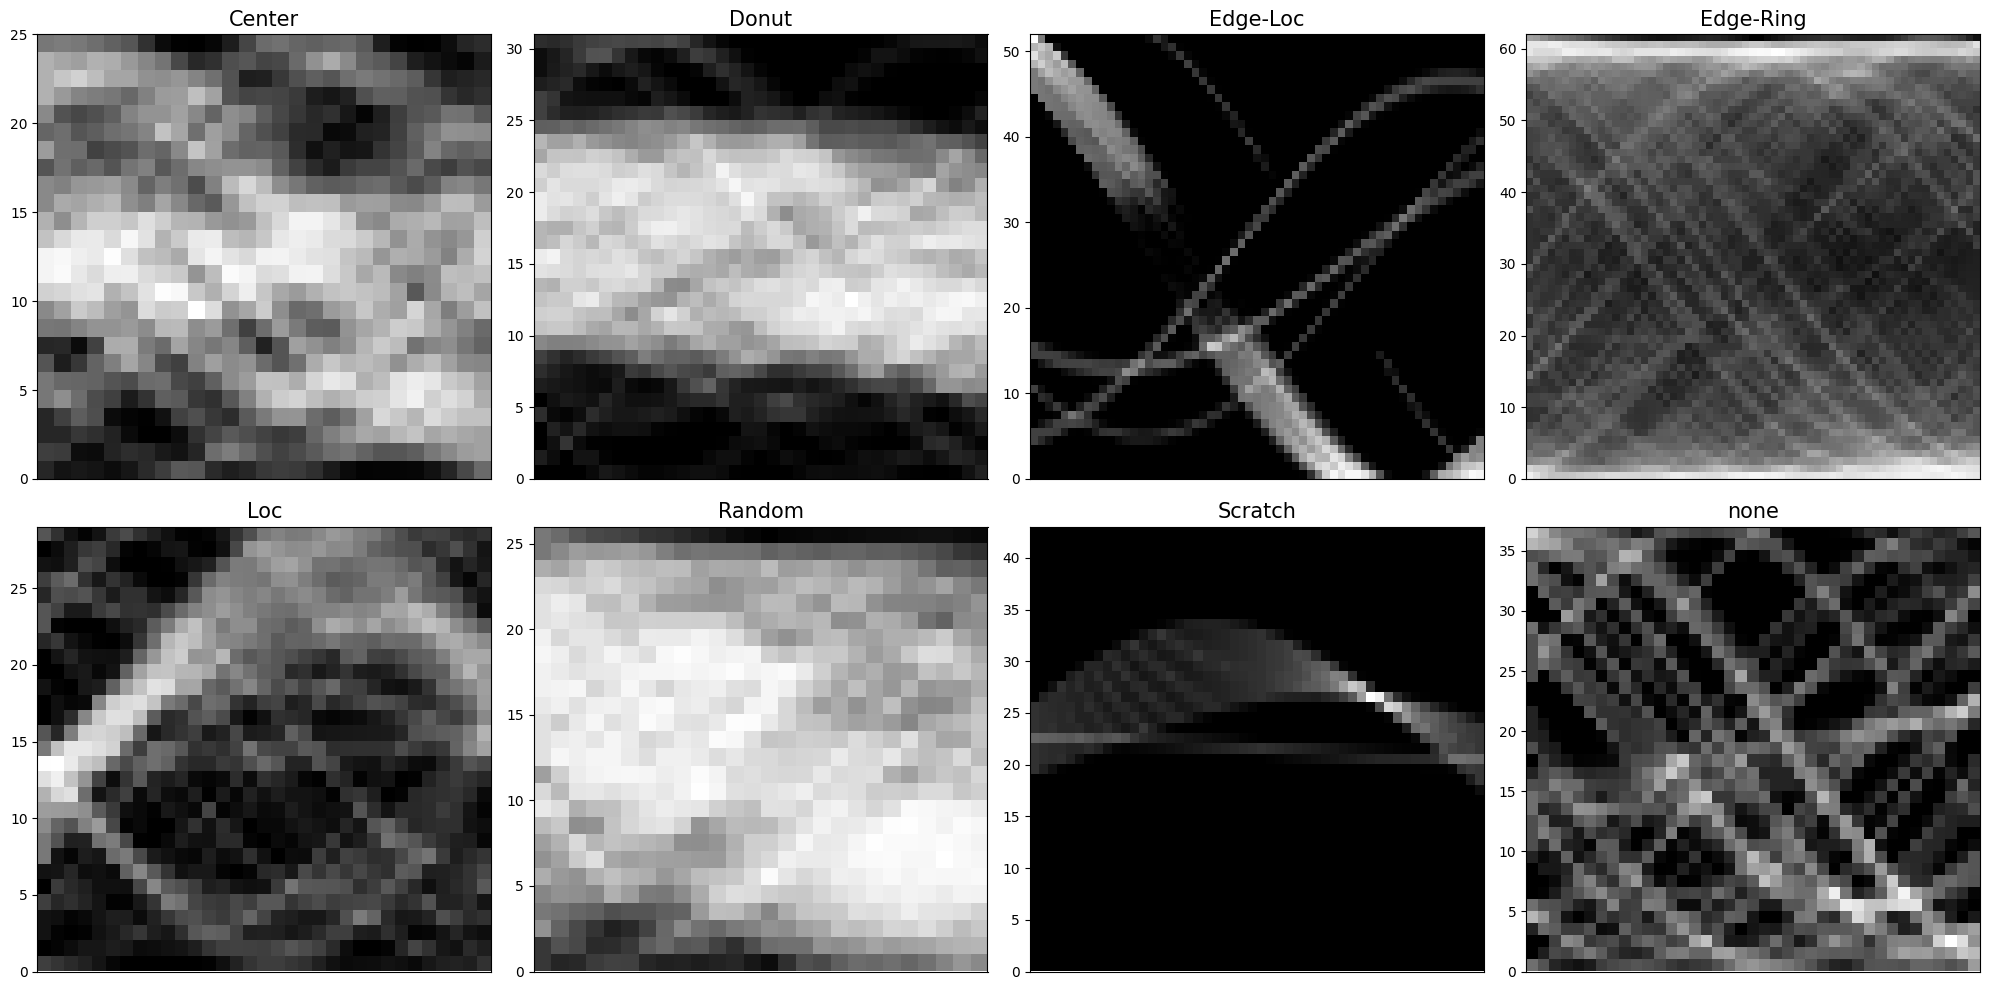

In [34]:
 #Change the 1s to 0s so that the wafer maps only contain two types of signals: faulty and not faulty

def change_val(img):
    img[img==1] = 0  
    return img

df3['new_waferMap'] = df3.waferMap.apply(change_val)
# Visualize randon transformation

from skimage.transform import radon

fig, ax = plt.subplots(nrows = 2, ncols = 4, figsize=(20, 10))
ax = ax.ravel(order='C')
for i in range(num_cat):
    cat = df3['failureType'].cat.categories[i]
    sample = df3.loc[df['failureType'] == cat].sample(sample_size)
    img = list(sample['waferMap'])[0]
    theta = np.linspace(0., 180., max(img.shape), endpoint=False)
    sinogram = radon(img, theta=theta)    
    ax[i].imshow(sinogram, cmap=plt.cm.Greys_r, extent=(0, 180, 0, sinogram.shape[0]), aspect='auto')
    ax[i].set_title(cat, fontsize=15)
    ax[i].set_xticks([])
plt.tight_layout()

plt.show() 

Η εικόνα παραπάνω δείχνει τα αποτελέσματα της μετατροπής Radon για 8 τυπικούς τύπους ελαττωμάτων.

Ωστόσο, επειδή οι δίσκοι wafer διαφέρουν σε μέγεθος, πρέπει να αποκτήσουμε χαρακτηριστικά με σταθερές διαστάσεις για να χρησιμοποιήσουμε τις τιμές της μετατροπής Radon ως χαρακτηριστικά. Στο επόμενο βήμα, χρησιμοποιούμε κυβική παρεμβολή για να αποκτήσουμε σταθερές διαστάσεις χαρακτηριστικών για το μέσο όρο της σειράς και την τυπική απόκλιση της σειράς από τη μετατροπή Radon, και για κάθε χαρακτηριστικό η διάσταση καθορίζεται σε 20. Θα εξάγουμε είκοσι χαρακτηριστικά από κάθε διάσταση, οπότε έχουμε συνολικά 40 χαρακτηριστικά βασισμένα στον Radon.

Η παρακάτω εικόνα δείχνει τα χαρακτηριστικά βασισμένα στον Radon για το μέσο όρο και την τυπική απόκλιση της σειράς για κάθε ελαττωματική κλάση σε επιλεκτικά δείγματα.

In [36]:
# Define functions for cubis interpolation

from scipy import interpolate

def cubic_inter_mean(img):
    theta = np.linspace(0., 180., max(img.shape), endpoint=False)
    sinogram = radon(img, theta=theta)
    xMean_Row = np.mean(sinogram, axis = 1)
    x = np.linspace(1, xMean_Row.size, xMean_Row.size)
    y = xMean_Row
    f = interpolate.interp1d(x, y, kind = 'cubic')
    xnew = np.linspace(1, xMean_Row.size, 20)
    ynew = f(xnew)/100   # use interpolation function returned by `interp1d`
    return ynew

def cubic_inter_std(img):
    theta = np.linspace(0., 180., max(img.shape), endpoint=False)
    sinogram = radon(img, theta=theta)
    xStd_Row = np.std(sinogram, axis=1)
    x = np.linspace(1, xStd_Row.size, xStd_Row.size)
    y = xStd_Row
    f = interpolate.interp1d(x, y, kind = 'cubic')
    xnew = np.linspace(1, xStd_Row.size, 20)
    ynew = f(xnew)/100   # use interpolation function returned by `interp1d`
    return ynew  

In [37]:
df3['fea_cub_mean'] = df3.waferMap.apply(cubic_inter_mean)
df3['fea_cub_std'] = df3.waferMap.apply(cubic_inter_std)

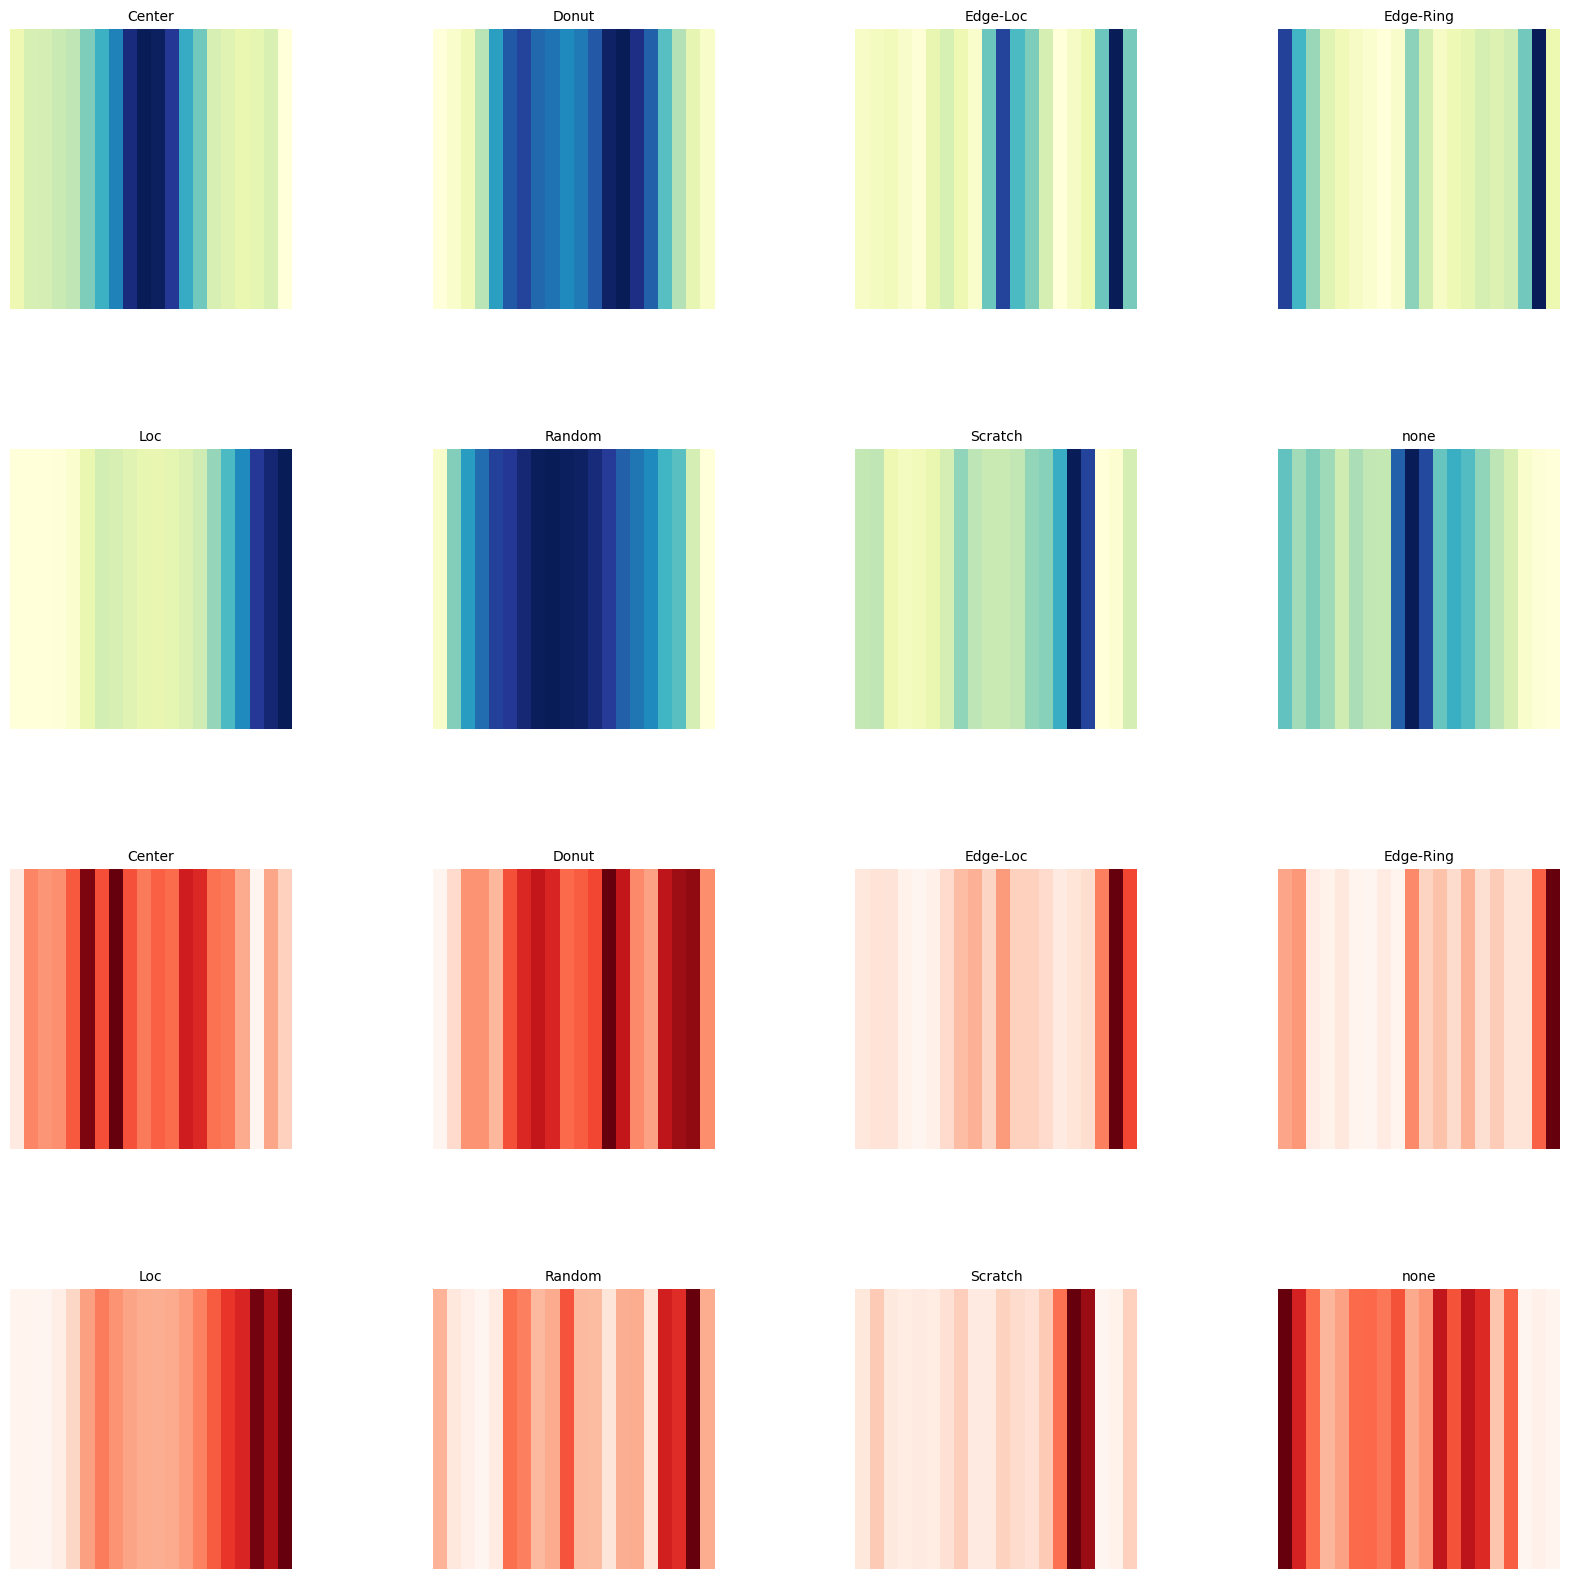

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Visualize Radon-based feature (interpolated from row mean and row standard deviation)

fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(20, 20))
ax = ax.ravel(order='C')

for i in range(num_cat):
    cat = df3['failureType'].cat.categories[i]
    sample = df3.loc[df3['failureType'] == cat].sample(sample_size)
    
    if not sample.empty:
        # Row mean (Θερμική εικόνα για row mean)
        img_mean = sample['fea_cub_mean'].iloc[0]
        sns.heatmap([img_mean], ax=ax[i], cmap='YlGnBu', cbar=False, xticklabels=False, yticklabels=False)
        ax[i].set_title(cat, fontsize=10)

        # Row standard deviation (Θερμική εικόνα για row standard deviation)
        img_std = sample['fea_cub_std'].iloc[0]
        sns.heatmap([img_std], ax=ax[i + num_cat], cmap='Reds', cbar=False, xticklabels=False, yticklabels=False)
        ax[i + num_cat].set_title(cat, fontsize=10)

# Ρυθμίσεις για τη διάταξη
plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.show()


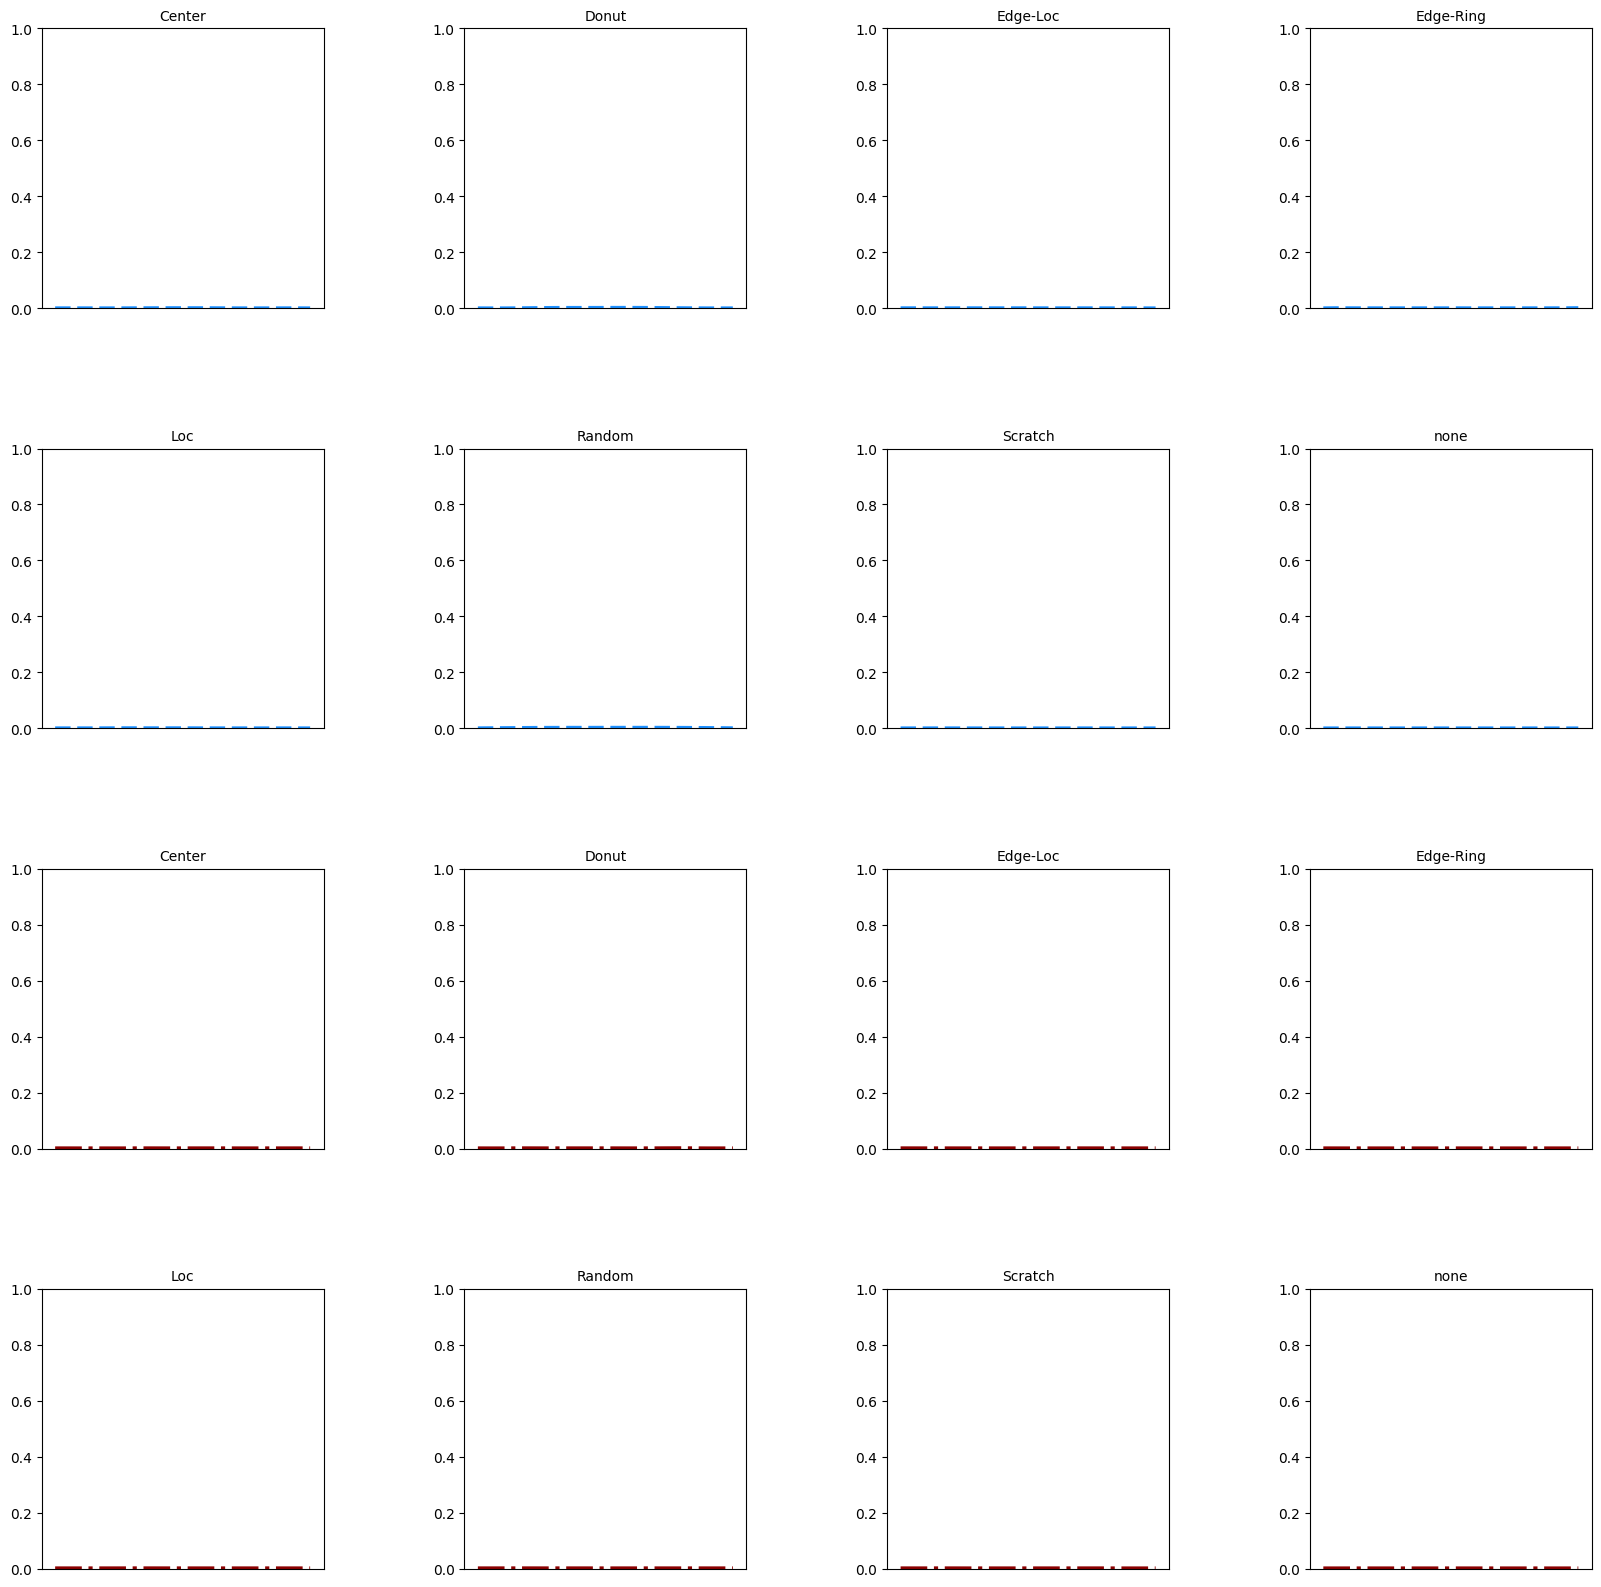

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# Visualize Radon-based feature (interpolated from row mean and row standard deviation)

fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(20, 20))
ax = ax.ravel(order='C')

for i in range(num_cat):
    cat = df3['failureType'].cat.categories[i]
    sample = df3.loc[df3['failureType'] == cat].sample(sample_size)
    
    if not sample.empty:
        # Row mean (Προσαρμοσμένο στυλ με μπλε χρώμα και μεγαλύτερο πάχος γραμμής)
        img_mean = sample['fea_cub_mean'].iloc[0]
        ax[i].plot(np.linspace(1, 20, 20), img_mean, color='dodgerblue', lw=3, linestyle='--')  # Προσαρμοσμένο στυλ
        ax[i].set_title(cat, fontsize=10)
        ax[i].set_xticks([])
        ax[i].set_xlim([0, 21])
        ax[i].set_ylim([0, 1])

        # Row standard deviation (Κόκκινο με παχύτερη γραμμή)
        img_std = sample['fea_cub_std'].iloc[0]
        ax[i + num_cat].plot(np.linspace(1, 20, 20), img_std, color='darkred', lw=3, linestyle='-.')  # Προσαρμοσμένο στυλ
        ax[i + num_cat].set_title(cat, fontsize=10)
        ax[i + num_cat].set_xticks([])
        ax[i + num_cat].set_xlim([0, 21])
        ax[i + num_cat].set_ylim([0, 1])

# Ρυθμίσεις για τη διάταξη
plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.show()


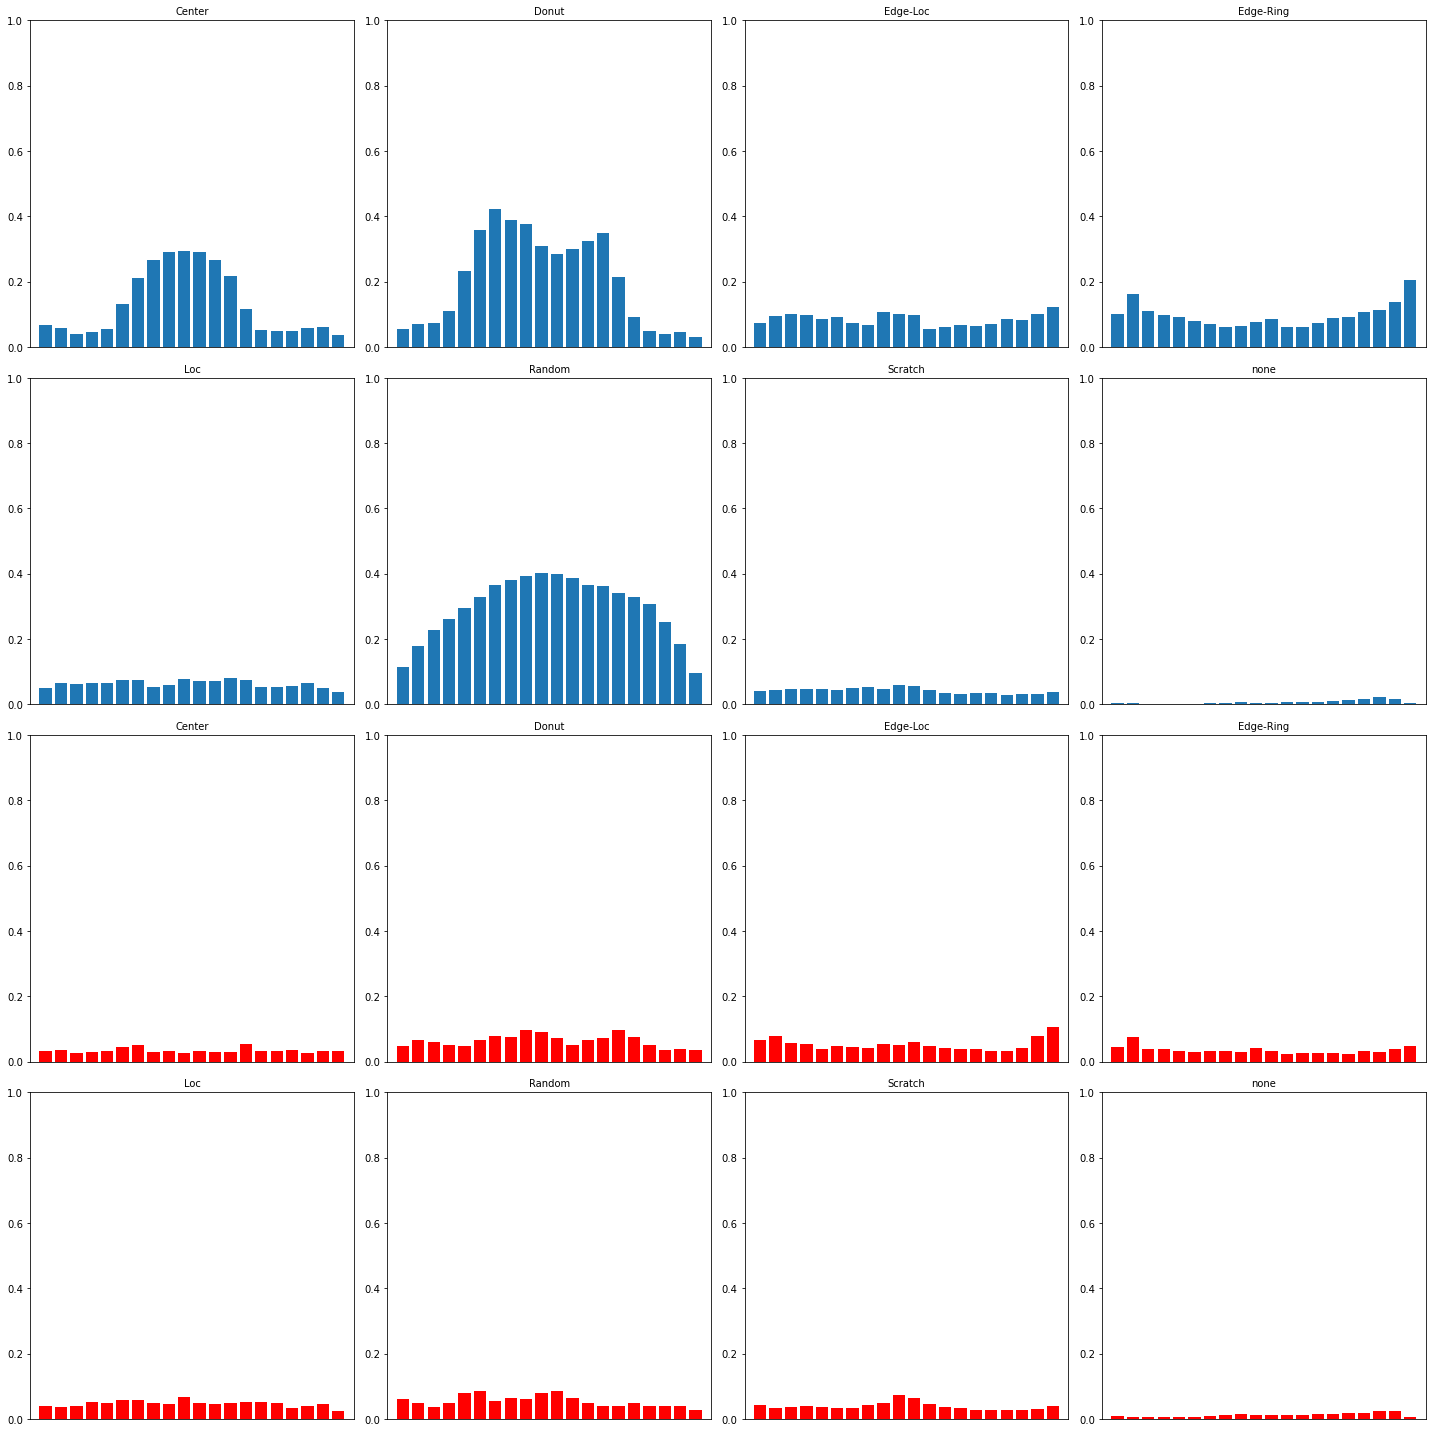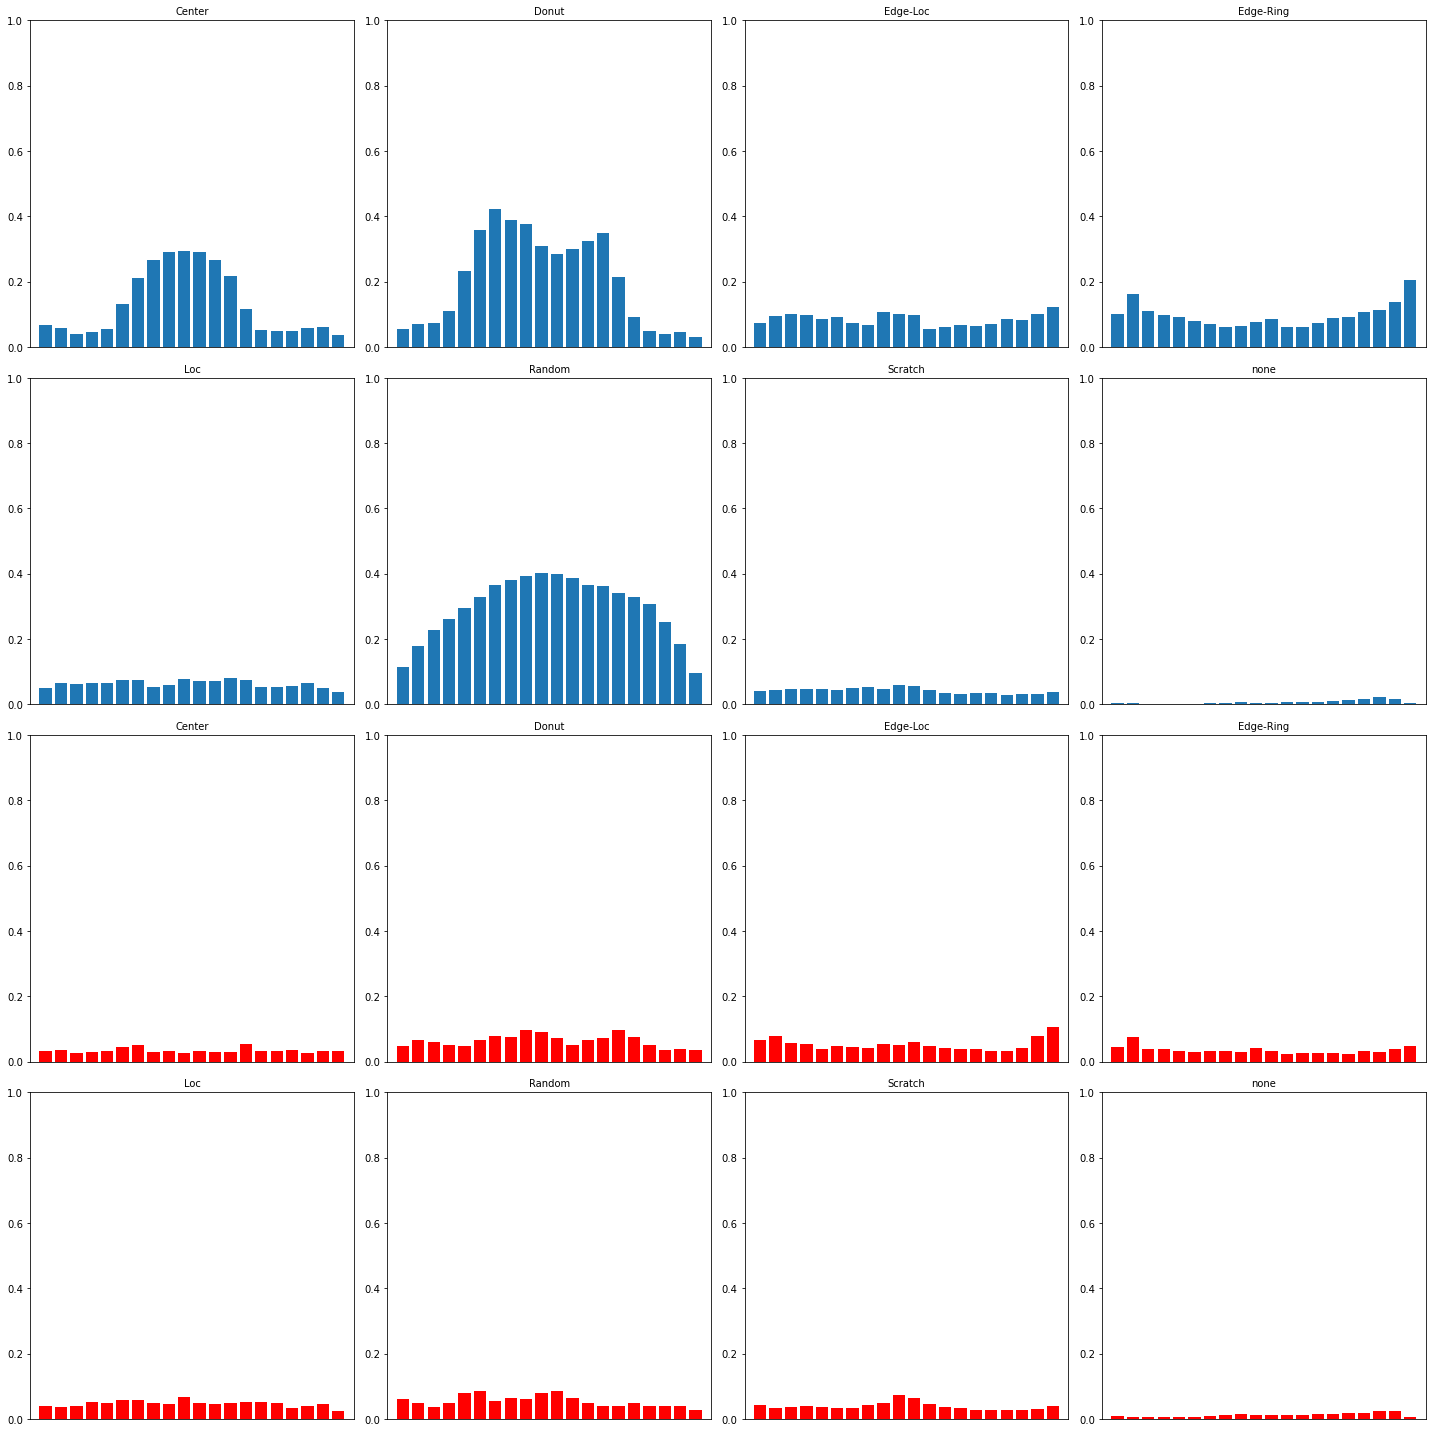

5.3 Χαρακτηριστικά βασισμένα στη Γεωμετρία (6)

Τα χαρακτηριστικά βασισμένα στη γεωμετρία καθορίζουν τα γεωμετρικά χαρακτηριστικά του wafer map. Χρησιμοποιήθηκε ένας αλγόριθμος επισημάνσεων περιοχών και επιλέχθηκε η περιοχή με τη μέγιστη έκταση ως η πιο σημαντική περιοχή, σύμφωνα με μια μελέτη. Η παρακάτω εικόνα απεικονίζει την πιο σημαντική περιοχή με τη μέγιστη έκταση για κάθε τύπο ελαττώματος του wafer map σε τυχαία δείγματα. Επίσης, δείχνει ότι μόνο τα πραγματικά μοτίβα ελαττώματος είναι ορατά και όλοι οι άλλοι θόρυβοι σε κάθε wafer map έχουν αφαιρεθεί.

Βασισμένοι στην πιο σημαντική περιοχή, προσπαθούμε να εξάγουμε 6 γεωμετρικά χαρακτηριστικά:

Περίμετρος: η περίμετρος της πιο σημαντικής περιοχής.

Εμβαδόν: το εμβαδόν της πιο σημαντικής περιοχής.

Μήκος του μικρού άξονα: το μήκος του μικρού άξονα των υποτιθέμενων ελλείψεων που περιβάλλουν την πιο σημαντική περιοχή με μέγιστη έκταση.

Μήκος του μεγάλου άξονα: το μήκος του μεγάλου άξονα των υποτιθέμενων ελλείψεων που περιβάλλουν την πιο σημαντική περιοχή με μέγιστη έκταση.

Συνοχή: το ποσοστό των ελαττωματικών dice στην υποτιθέμενη κυρτή περίμετρο που περιβάλλει την πιο σημαντική περιοχή με μέγιστη έκταση.

Εκκεντρότητα: το περίγραμμα της υποτιθέμενης έλλειψης που περιβάλλει την πιο σημαντική περιοχή με μέγιστη έκταση.

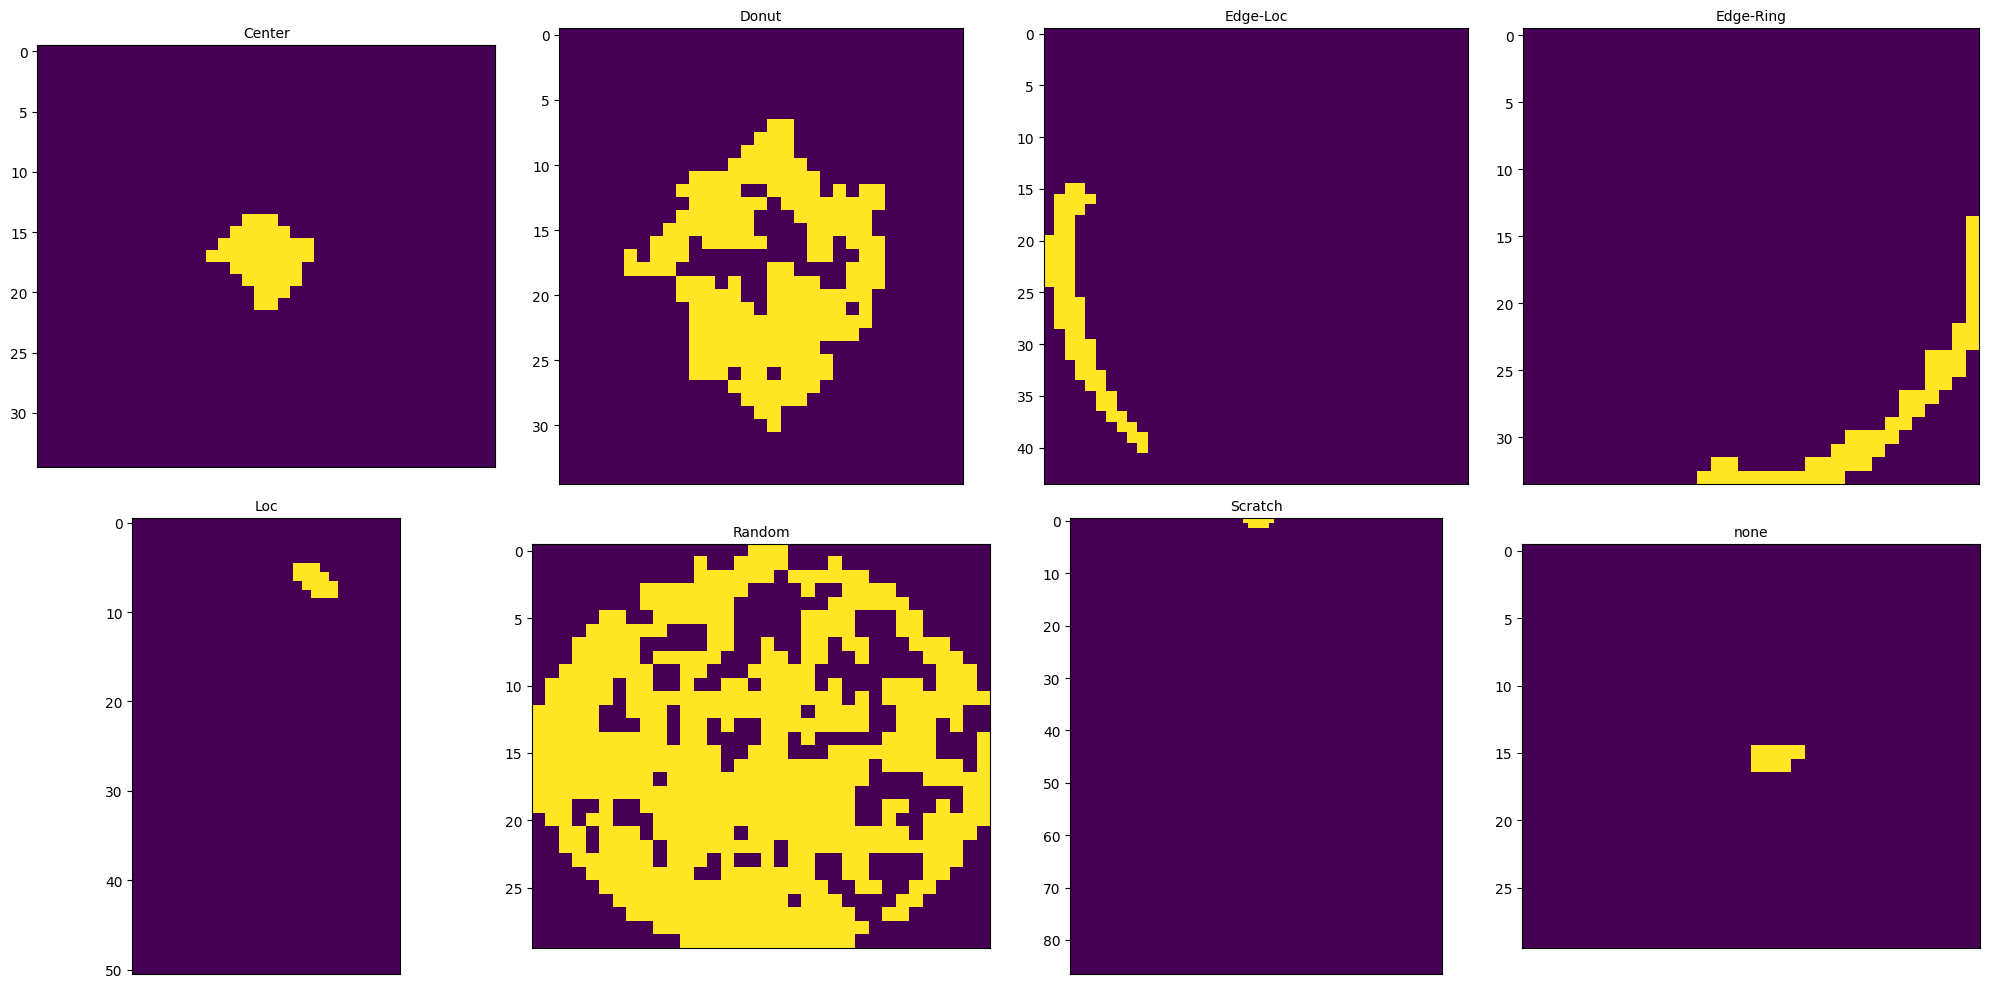

In [48]:
from skimage import measure
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
ax = ax.ravel(order='C')

for i in range(8):
    cat = df3['failureType'].cat.categories[i]
    sample = df3.loc[df3['failureType'] == cat].sample(sample_size)
    img = list(sample['waferMap'])[0]
    
    # Δημιουργία μιας κενής εικόνας με διαστάσεις ίδιες με αυτές της εικόνας wafermap
    zero_img = np.zeros(img.shape)
    
    # Εφαρμογή της συνάρτησης label() με τη σωστή παράμετρο "connectivity"
    img_labels = measure.label(img, connectivity=1, background=0)  # Η παράμετρος "neighbors" αφαιρέθηκε
    
    img_labels = img_labels - 1  # Μετατροπή των labels σε 0-based indexing
    
    # Αν δεν υπάρχουν περιοχές, τότε ο αριθμός περιοχών είναι 0
    if img_labels.max() == 0:
        no_region = 0
    else:
        # Αν υπάρχουν περιοχές, βρες τη συχνότερη τιμή (mode)
        info_region = stats.mode(img_labels[img_labels > -1], axis=None)
        no_region = info_region[0]

    # Δημιουργία νέας εικόνας όπου η περιοχή με τη μέγιστη συχνότητα θα έχει την τιμή 2
    zero_img[np.where(img_labels == no_region)] = 2
    
    # Εμφάνιση του αποτελέσματος
    ax[i].imshow(zero_img)
    ax[i].set_title(cat, fontsize=10)
    ax[i].set_xticks([])

plt.tight_layout()
plt.show()


In [68]:
info_region = stats.mode(img_labels[img_labels > 0], axis=None)
print(f"Mode Value: {info_region.mode}")
print(f"Count: {info_region.count}")


Mode Value: 13
Count: 7


In [69]:
import numpy as np
from skimage import measure
from scipy import stats

# Function to calculate distance from the centroid
def cal_dist(img, x, y):
    dim0 = np.size(img, axis=0)    
    dim1 = np.size(img, axis=1)
    dist = np.sqrt((x - dim0 / 2)**2 + (y - dim1 / 2)**2)
    return dist  

# Function to extract geometric features
def fea_geom(img):
    norm_area = img.shape[0] * img.shape[1]
    norm_perimeter = np.sqrt((img.shape[0])**2 + (img.shape[1])**2)
    
    # Label the connected components
    img_labels = measure.label(img, connectivity=1, background=0)

    # Handle case where there are no labeled regions
    if img_labels.max() == 0:
        return (0, 0, 0, 0, 0, 0)  # No region found, return zeros
    
    # Find the most frequent label (region)
    info_region = stats.mode(img_labels[img_labels > 0], axis=None)

    # Ensure we correctly extract the mode value
    mode_value = info_region.mode
    if isinstance(mode_value, np.ndarray):  # When mode_value is an array
        mode_value = mode_value[0]
    
    if info_region.count == 0:  # If no valid regions found
        return (0, 0, 0, 0, 0, 0)

    # Zero-indexed region
    no_region = mode_value - 1

    # Extract region properties
    prop = measure.regionprops(img_labels)
    
    # Ensure there are enough regions
    if len(prop) > no_region:  # Check if the region is valid
        prop_area = prop[no_region].area / norm_area
        prop_perimeter = prop[no_region].perimeter / norm_perimeter
        prop_cent = prop[no_region].local_centroid
        prop_cent_dist = cal_dist(img, prop_cent[0], prop_cent[1])
        prop_majaxis = prop[no_region].major_axis_length / norm_perimeter
        prop_minaxis = prop[no_region].minor_axis_length / norm_perimeter
        prop_ecc = prop[no_region].eccentricity
        prop_solidity = prop[no_region].solidity
    else:
        # Return zeros if the region is not valid
        prop_area = prop_perimeter = prop_majaxis = prop_minaxis = prop_ecc = prop_solidity = 0
    
    return prop_area, prop_perimeter, prop_majaxis, prop_minaxis, prop_ecc, prop_solidity

# Apply function to 'waferMap' column
df3['fea_geom'] = df3.waferMap.apply(fea_geom)


5.4. Συνδυασμός Εξαγόμενων Χαρακτηριστικών

Αφού έχουμε εξάγει πολυδιάστατα χαρακτηριστικά, όπως είκοσι χαρακτηριστικά βασισμένα στην πυκνότητα, έξι χαρακτηριστικά βασισμένα στη γεωμετρία και σαράντα χαρακτηριστικά βασισμένα στην μετατροπή Radon για κάθε wafer map, το επόμενο βήμα είναι να συνδυάσουμε όλα αυτά τα χαρακτηριστικά. Καθώς κάθε χαρακτηριστικό αντιπροσωπεύει μια συγκεκριμένη παράμετρο διαφορετικών ελαττωμάτων του wafer, ο συνδυασμός τους μπορεί να παίξει καθοριστικό ρόλο στην αναγνώριση των ελαττωμάτων. Συνεπώς, έχουμε συνολικά 59 (δηλαδή, 13+6+40 = 59) αποτελεσματικά χαρακτηριστικά για κάθε wafer map, τα οποία χρησιμοποιούμε για ανάλυση μηχανικής μάθησης (ML).

In [70]:
# Combine the features

df_all=df3.copy()
a=[df_all.fea_reg.iloc[i] for i in range(df_all.shape[0])] #13
b=[df_all.fea_cub_mean.iloc[i] for i in range(df_all.shape[0])] #20
c=[df_all.fea_cub_std.iloc[i] for i in range(df_all.shape[0])] #20
d=[df_all.fea_geom.iloc[i] for i in range(df_all.shape[0])] #6
fea_all = np.concatenate((np.array(a),np.array(b),np.array(c),np.array(d)),axis=1) #59 in total
# Create target column array

label=[df_all.failureNum.iloc[i] for i in range(df_all.shape[0])]
label=np.array(label)

6. Machine Learning Classifiers
We will be experimenting with different machine learning classifiers:

Support Vector Machine (SVM)
Logistic Regressio (LR)
Random Forest Classifier
First let's split the train and test sets:

In [73]:
pip install --upgrade theano


Note: you may need to restart the kernel to use updated packages.


In [75]:
pip install tensorflow


Note: you may need to restart the kernel to use updated packages.


In [77]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


2025-07-18 07:46:49.011546: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752824809.244028      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752824809.311079      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [81]:
from collections import Counter


In [82]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical  # Κάθε κλάση (όπως η `np_utils` στο Keras) μπορεί να έχει τον αντίστοιχο της στο TensorFlow

# Φορτώνουμε τα δεδομένα (βεβαιώσου ότι το `fea_all` και `label` είναι σωστά φορτωμένα)
X = fea_all
y = label

# Διαχωρίζουμε τα δεδομένα σε εκπαιδευτικά και δοκιμαστικά
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
print('Training target statistics: {}'.format(Counter(y_train)))
print('Testing target statistics: {}'.format(Counter(y_test)))


Training target statistics: Counter({5: 389, 6: 384, 8: 381, 1: 380, 3: 376, 4: 370, 2: 367, 0: 353})
Testing target statistics: Counter({0: 147, 2: 133, 4: 130, 3: 124, 1: 120, 8: 119, 6: 116, 5: 111})


In [83]:
# Αν το y είναι κατηγορικό, το μετατρέπουμε σε one-hot encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

6.1. Μηχανή Υποστήριξης Διανυσμάτων (Support Vector Machine)
Αυτό το module υλοποιεί έναν αλγόριθμο πολλαπλής κατηγοριοποίησης και πολλαπλής ετικέτας και επιλέξαμε την πολλαπλή κατηγοριοποίηση One-VS-One SVM ως το μοντέλο μας, βασισμένο σε βιβλιογραφικές ανασκοπήσεις για αυτό το σύνολο δεδομένων.

One-vs-the-rest:
Η στρατηγική one-vs-the-rest αποτελείται από την εκπαίδευση ενός ταξινομητή ανά κατηγορία. Για κάθε ταξινομητή, η κατηγορία εκπαιδεύεται απέναντι σε όλες τις υπόλοιπες κατηγορίες.

One-vs-one:
Ο ταξινομητής one-vs-one δημιουργεί έναν ταξινομητή για κάθε ζεύγος κατηγοριών.



In [87]:
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsOneClassifier
from sklearn.model_selection import cross_val_score

# Αν το y είναι One-Hot-Encoded, το μετατρέπουμε σε 1D
y_train = y_train.argmax(axis=1)
y_test = y_test.argmax(axis=1)

# Δημιουργία του μοντέλου One-vs-One με LinearSVC
SVM = OneVsOneClassifier(LinearSVC(random_state=RANDOM_STATE)).fit(X_train, y_train)

# Πρόβλεψη στις εκπαιδευτικές και δοκιμαστικές καταστάσεις
y_train_pred = SVM.predict(X_train)
y_test_pred = SVM.predict(X_test)

# Εκτίμηση του μοντέλου με cross-validation
scores = cross_val_score(SVM, X_test, y_test, cv=10, scoring='accuracy')

# Εκτύπωση του μέσου όρου των ακριβειών από το cross-validation
print(f"Accuracy score for Support Vector Machine: \n {scores.mean()}")


Accuracy score for Support Vector Machine: 
 0.6570000000000001


In [88]:
# Define function to present results

import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    labels = failure_types
    plt.xticks(ticks = range(8), labels = labels)
    plt.yticks(ticks = range(8), labels = labels)

Confusion matrix, without normalization
Normalized confusion matrix


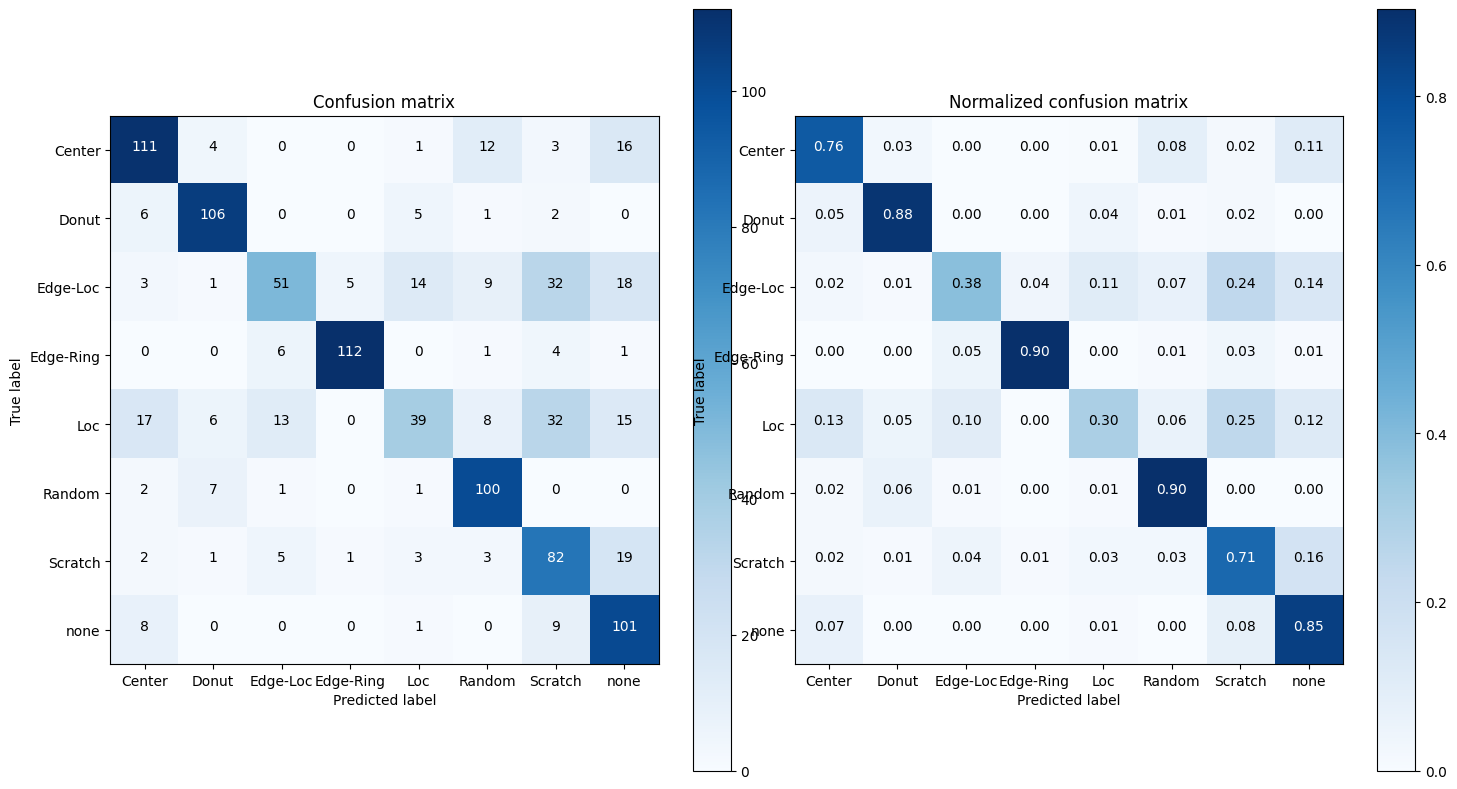

In [89]:
# Compute confusion matrix

cnf_matrix = confusion_matrix(y_test, y_test_pred)
np.set_printoptions(precision=2)

from matplotlib import gridspec
fig = plt.figure(figsize=(15, 8)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1]) 

## Plot non-normalized confusion matrix

plt.subplot(gs[0])
plot_confusion_matrix(cnf_matrix, title='Confusion matrix')

# Plot normalized confusion matrix

plt.subplot(gs[1])
plot_confusion_matrix(cnf_matrix, normalize=True, title='Normalized confusion matrix')

plt.show()

6.2 Logistic Regression

In [90]:
# Implement logistic regression

from sklearn.linear_model import LogisticRegression

LR = LogisticRegression().fit(X_train, y_train)
y_train_pred = LR.predict(X_train)
y_test_pred = LR.predict(X_test)
scores = cross_val_score(LR, X_test, y_test, cv=10, scoring='accuracy')
print(f"Accuracy score for the logistic regression: \n {scores.mean()}")

Accuracy score for the logistic regression: 
 0.627


Confusion matrix, without normalization
Normalized confusion matrix


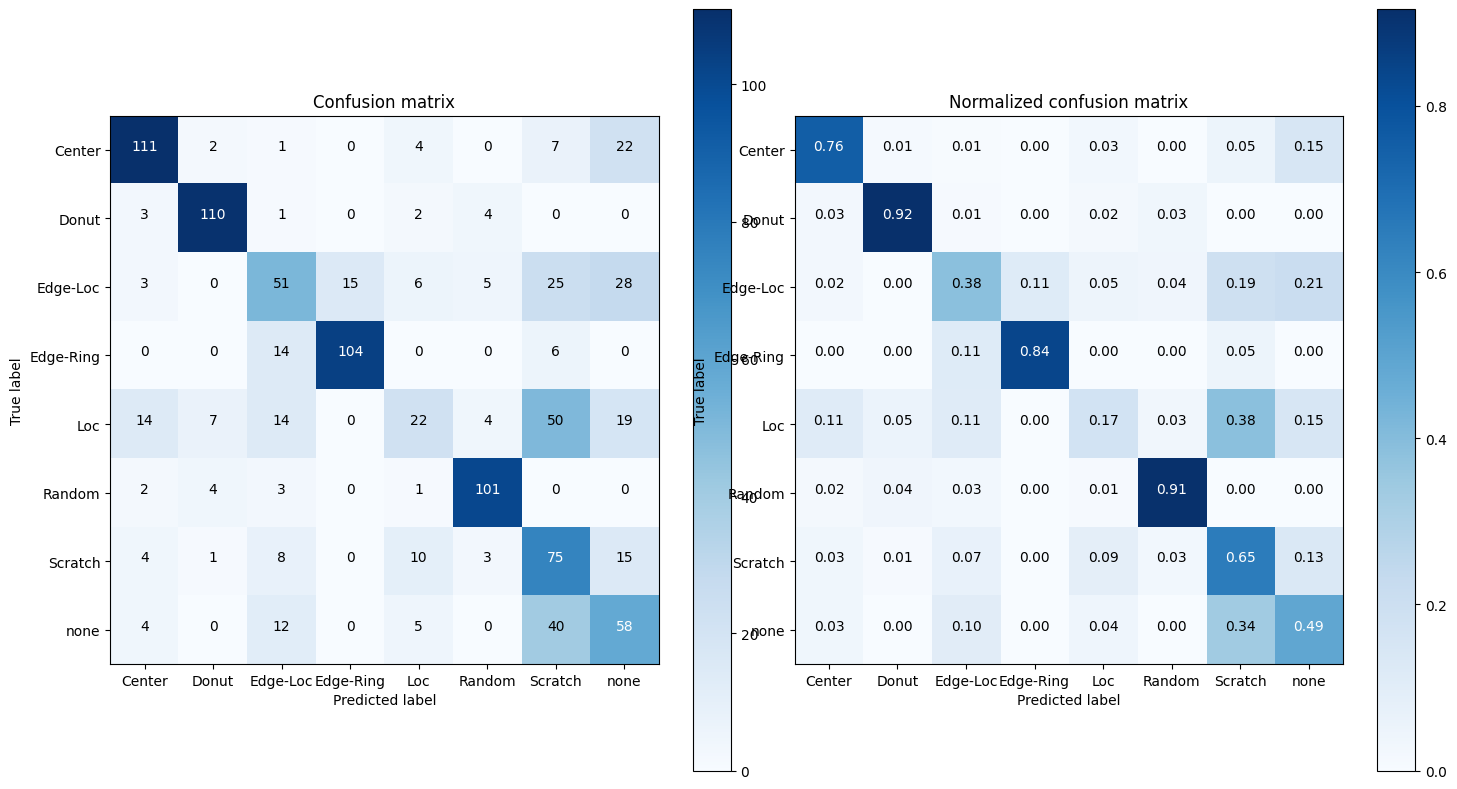

In [91]:
# Compute confusion matrix

cnf_matrix = confusion_matrix(y_test, y_test_pred)
np.set_printoptions(precision=2)

from matplotlib import gridspec
fig = plt.figure(figsize=(15, 8)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1]) 

## Plot non-normalized confusion matrix

plt.subplot(gs[0])
plot_confusion_matrix(cnf_matrix, title='Confusion matrix')

# Plot normalized confusion matrix

plt.subplot(gs[1])
plot_confusion_matrix(cnf_matrix, normalize=True, title='Normalized confusion matrix')

plt.show()

6.3. Random Forest Classifier

In [92]:
# Implement random forest classifier

from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier().fit(X_train, y_train)
y_train_pred = RF.predict(X_train)
y_test_pred = RF.predict(X_test)
scores = cross_val_score(RF, X_test, y_test, cv=10, scoring='accuracy')
print(f"Accuracy score for the random forest classifier: \n {scores.mean()}")

Accuracy score for the random forest classifier: 
 0.7850000000000001


Confusion matrix, without normalization
Normalized confusion matrix


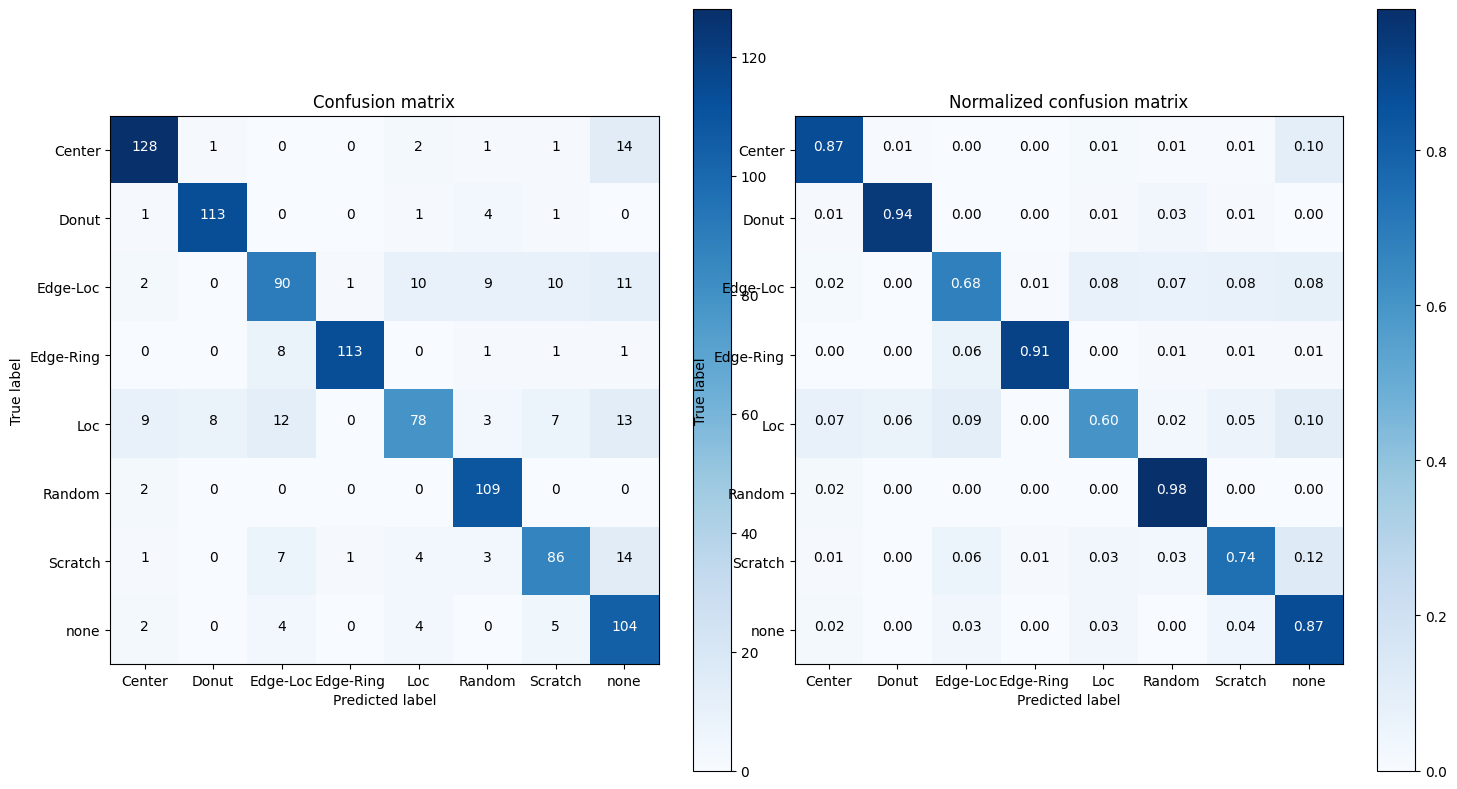

In [93]:
# Compute confusion matrix

cnf_matrix = confusion_matrix(y_test, y_test_pred)
np.set_printoptions(precision=2)

from matplotlib import gridspec
fig = plt.figure(figsize=(15, 8)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1]) 

## Plot non-normalized confusion matrix

plt.subplot(gs[0])
plot_confusion_matrix(cnf_matrix, title='Confusion matrix')

# Plot normalized confusion matrix

plt.subplot(gs[1])
plot_confusion_matrix(cnf_matrix, normalize=True, title='Normalized confusion matrix')

plt.show()

6.4. Hyperparameter Tuning for Random Forest Classifier

In [94]:
# Look at parameters used by our current forest

from pprint import pprint
print('Parameters currently in use:\n')
pprint(RF.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [95]:
# Hyperparemeer tuning using grid search

from sklearn.model_selection import GridSearchCV

n_estimators = [100, 300, 500]
max_depth = [30, 40, 50]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 5] 
random.seed(10)
hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

gridF = GridSearchCV(RF, hyperF, cv = 3, verbose = 1, 
                      n_jobs = -1)
bestF = gridF.fit(X_train, y_train)

Fitting 3 folds for each of 81 candidates, totalling 243 fits


In [96]:
# Look at the best parameters

best = gridF.best_params_
print(best)

{'max_depth': 40, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


In [98]:
# Implement random forest classifier with new parameters

RF = RandomForestClassifier(
    max_depth=best['max_depth'],
    min_samples_leaf=best['min_samples_leaf'],
    min_samples_split=best['min_samples_split'],
    n_estimators=best['n_estimators']
)

# Fit the model to the training data
RF.fit(X_train, y_train)

# Predict on the training and test sets
y_train_pred = RF.predict(X_train)
y_test_pred = RF.predict(X_test)

# Cross-validation to get accuracy score
scores = cross_val_score(RF, X_test, y_test, cv=10, scoring='accuracy')

# Print the accuracy score
print(f"Accuracy score for random forest classifier: \n {scores.mean()}")


Accuracy score for random forest classifier: 
 0.7939999999999999


Confusion matrix, without normalization
Normalized confusion matrix


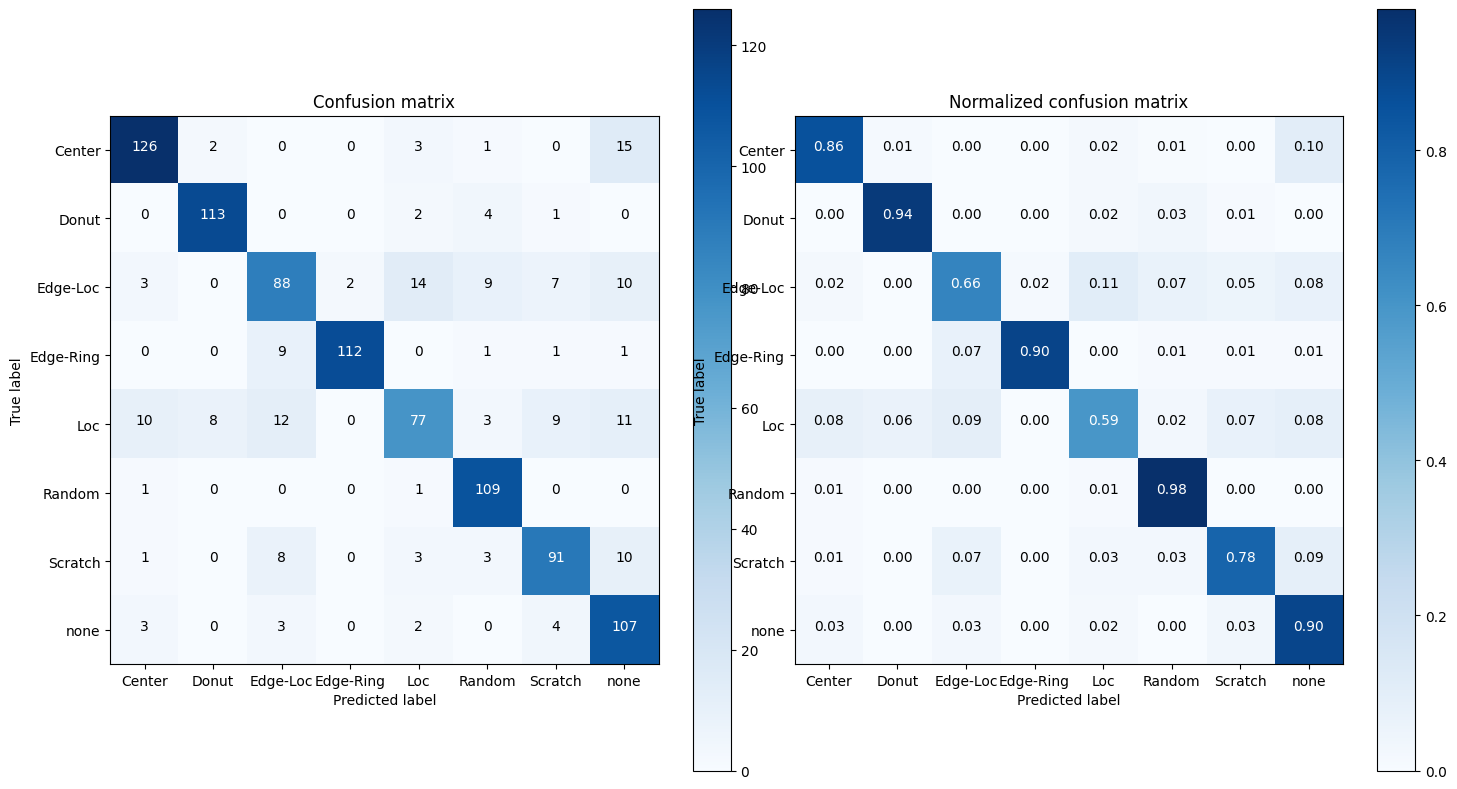

In [99]:
# Compute confusion matrix

cnf_matrix = confusion_matrix(y_test, y_test_pred)
np.set_printoptions(precision=2)

from matplotlib import gridspec
fig = plt.figure(figsize=(15, 8)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1]) 

## Plot non-normalized confusion matrix

plt.subplot(gs[0])
plot_confusion_matrix(cnf_matrix, title='Confusion matrix')

# Plot normalized confusion matrix

plt.subplot(gs[1])
plot_confusion_matrix(cnf_matrix, normalize=True, title='Normalized confusion matrix')

plt.show()

7. Συμπεράσματα
Σε αυτό το έργο, αναπτύξαμε μια μέθοδο ταξινόμησης μοτίβων ελαττωμάτων χρησιμοποιώντας έναν ταξινομητή τυχαίων δασών με σκορ ακρίβειας 0.7939. Ο ταξινομητής τυχαίων δασών είναι μια μέθοδος συνόλου για ταξινόμηση, η οποία λειτουργεί δημιουργώντας μια πληθώρα δέντρων απόφασης κατά τη διάρκεια της εκπαίδευσης. Μεταξύ των διαφορετικών τύπων ελαττωμάτων στο wafer, η προτεινόμενη μέθοδος επιτυγχάνει την υψηλότερη ακρίβεια στην ανίχνευση χαρτών wafer με τυχαία ελαττώματα, ελαττώματα με άκρη-δακτύλιο και ελαττώματα τύπου ντόνατ. Πραγματοποιήσαμε βελτιστοποίηση υπερπαραμέτρων για να ανακαλύψουμε το καλύτερο μοντέλο. Αυτό επιτεύχθηκε μέσω της μηχανικής χαρακτηριστικών, όπου τα χαρακτηριστικά του wafer map αποσυντίθενται και συνδυάζονται για να δημιουργηθούν χαρακτηριστικά βασισμένα σε πυκνότητα, τυχαία και γεωμετρία.